# Predicting US Census Income Category with Apache Spark

## BINARY CLASSIFICATION : LOGISTIC REGRESSION

US Adult Census data relating income to social factors such as Age, Education, race etc.

The Us Adult income dataset was extracted by Barry Becker from the 1994 US Census Database. The data set consists of anonymous information such as occupation, age, native country, race, capital gain, capital loss, education, work class and more. Each row is labelled as either having a salary greater than ">50K" or "<=50K".

This Data set is split into two CSV files, named `adult-training.txt` and `adult-test.txt`.

The goal here is to train a binary classifier on the training dataset to predict the column income_bracket which has two possible values ">50K" and "<=50K" and evaluate the accuracy of the classifier with the test dataset.

Note that the dataset is made up of categorical and continuous features. It also contains missing values. The categorical columns are: workclass, education, marital_status, occupation, relationship, race, gender, native_country

The continuous columns are: age, education_num, capital_gain, capital_loss, hours_per_week.

This Dataset was obtained from the UCI repository, it can be found on:

https://archive.ics.uci.edu/ml/datasets/census+income  
http://mlr.cs.umass.edu/ml/machine-learning-databases/adult/

In [1]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
from pyspark.sql.functions import col, udf
import pyspark.sql.functions as F

from pyspark.ml.classification import LogisticRegression

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel

from pyspark.ml.feature import StringIndexer, OneHotEncoder, StandardScaler, VectorAssembler

from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Visualiztion
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from pylab import rcParams
rcParams['figure.figsize'] = 20, 4

In [4]:
# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

## 1. Creating the Spark Session

In [5]:
os.environ['SPARK_HOME']

'D:\\Work\\spark-2.3.0-bin-hadoop2.7'

In [6]:
spark = SparkSession.builder.master("local[*]").appName("predict-us-census-income").getOrCreate()
spark

In [7]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=predict-us-census-income>

In [8]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

## 2. Load The Data From a File Into a Dataframe

In [9]:
ADULT_TRAIN_DATA = 'data/adult-training.csv'
ADULT_TEST_DATA = 'data/adult-test.csv'

In [10]:
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("age", IntegerType(), nullable=True),
    StructField("workclass", StringType(), nullable=True),
    StructField("fnlgwt", DoubleType(), nullable=True),
    StructField("education", StringType(), nullable=True),
    StructField("education_num", DoubleType(), nullable=True),
    StructField("marital_status", StringType(), nullable=True),
    StructField("occupation", StringType(), nullable=True),
    StructField("relationship", StringType(), nullable=True),
    StructField("race", StringType(), nullable=True),
    StructField("sex", StringType(), nullable=True),
    StructField("capital_gain", DoubleType(), nullable=True),
    StructField("capital_loss", DoubleType(), nullable=True),
    StructField("hours_per_week", DoubleType(), nullable=True),
    StructField("native_country", StringType(), nullable=True),
    StructField("income", StringType(), nullable=True)]
)

In [11]:
# Load training data
train_df = (spark
                  .read
                  .csv(path=ADULT_TRAIN_DATA, schema=schema, ignoreLeadingWhiteSpace=True, ignoreTrailingWhiteSpace=True))

In [12]:
train_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlgwt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



In [13]:
# Load testing data
test_df = (spark
                  .read
                  .csv(path=ADULT_TEST_DATA, schema=schema, ignoreLeadingWhiteSpace=True, ignoreTrailingWhiteSpace=True))

## 3. Understanding the Distribution of various Features

In [14]:
# How many records in each data set
print('Training Samples: {0}, Test Samples: {1}.'.format(train_df.count(), test_df.count()))

Training Samples: 32561, Test Samples: 16281.


In [15]:
train_df.groupBy('income').count().withColumn('%age', F.round(col('count') / train_df.count(), 2)).toPandas()

,income,count,%age
0,<=50K,24720,0.76
1,>50K,7841,0.24


In [16]:
test_df.groupBy('income').count().withColumn('%age', F.round(col('count') / test_df.count(), 2)).toPandas()

,income,count,%age
0,<=50K.,12435,0.76
1,>50K.,3846,0.24


We can clearly see a type in the income label for test set. The labels are `<=50K.` and `>50K.` instead of `<=50K` and `>50K` .

**Fix Typos in Test Set:**

In [17]:
# There is a typo in the test set the values are '<=50K.' & '>50K.' instead of '<=50K' & '>50K'
test_df = test_df.replace(to_replace='<=50K.', value='<=50K', subset=['income'])
test_df = test_df.replace(to_replace='>50K.', value='>50K', subset=['income'])

**How the income labels are distributed between the training set and the test set:**

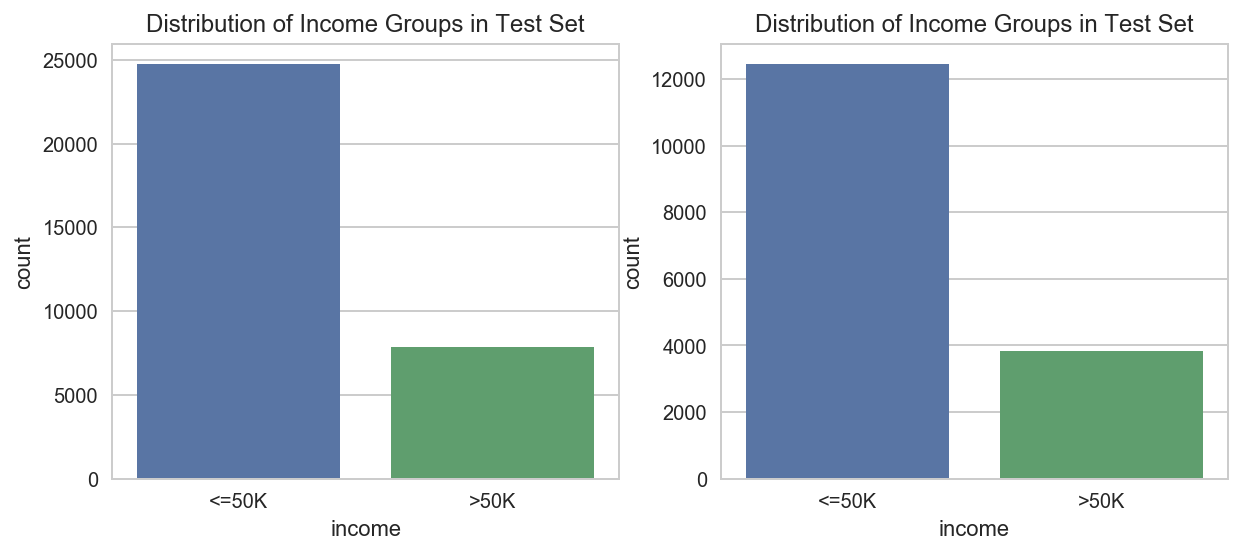

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4), sharex=False, sharey=False)

g = sns.countplot('income', data=train_df.select('income').toPandas(), ax=axes[0])
axes[0].set_title('Distribution of Income Groups in Test Set')

g = sns.countplot('income', data=test_df.select('income').toPandas(), ax=axes[1])
axes[1].set_title('Distribution of Income Groups in Test Set');

We see almost the same distribution of income labels in the different data sets.

**How the Age is distributed between the training set and the test set:**

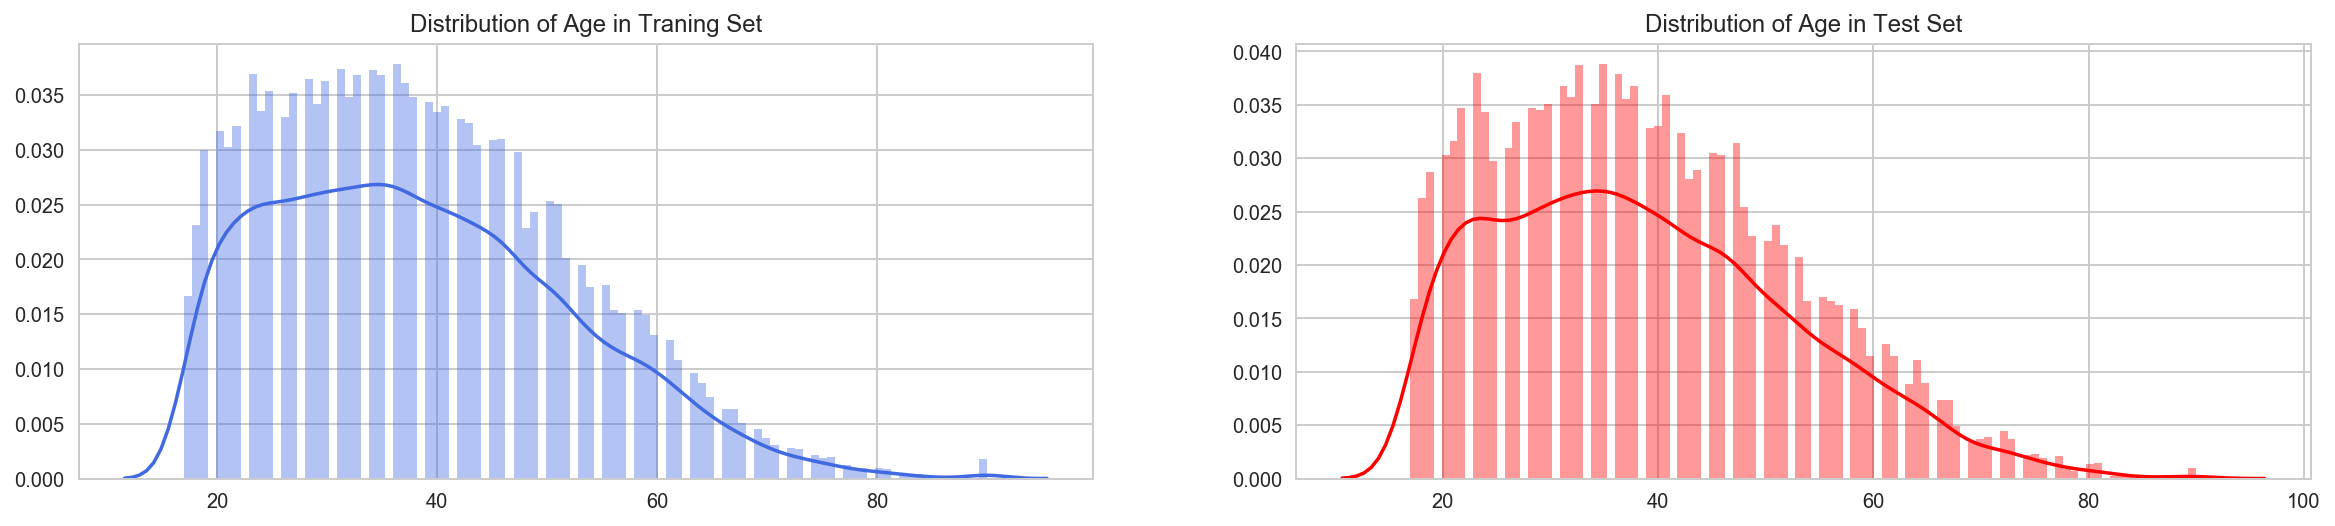

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)

sns.distplot(train_df.select('age').toPandas(), bins=100, color='royalblue', ax=axes[0]);
axes[0].set_title('Distribution of Age in Traning Set');

sns.distplot(test_df.select('age').toPandas(), bins=100, color='red', ax=axes[1])
axes[1].set_title('Distribution of Age in Test Set');

**How the Income is distributed across Workclass between the training set and the test set:**

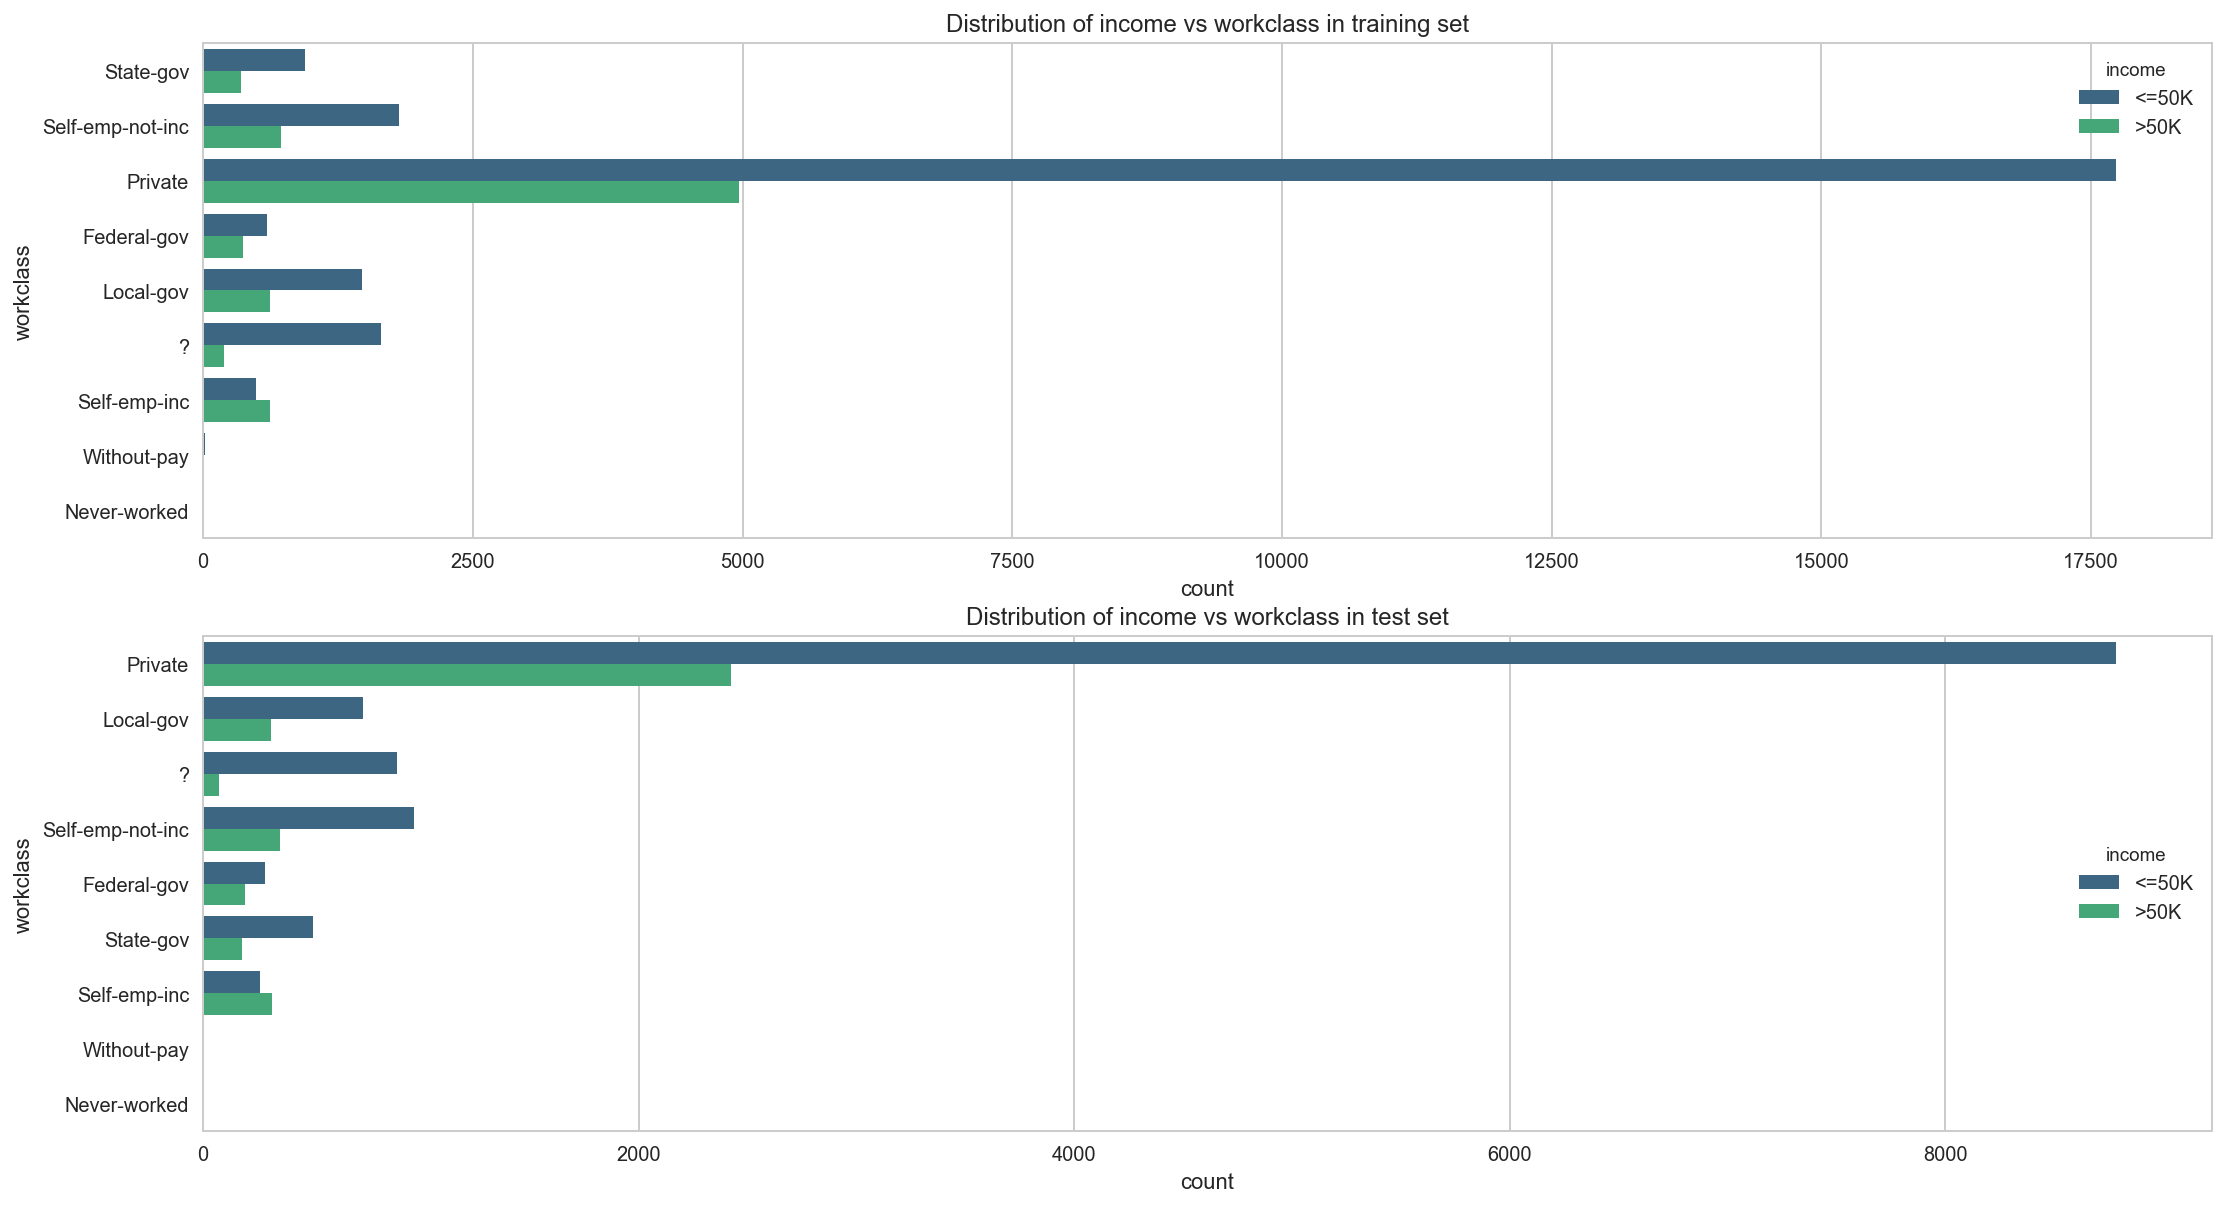

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 10), sharex=False, sharey=False)

sns.countplot(y='workclass', hue='income', data=train_df.select('workclass', 'income').toPandas(), palette="viridis", ax=axes[0])
axes[0].set_title('Distribution of income vs workclass in training set')

sns.countplot(y='workclass', hue='income', data=test_df.select('workclass', 'income').toPandas(), palette="viridis", ax=axes[1])
axes[1].set_title('Distribution of income vs workclass in test set');

Most people are employed in the Private Sector. Looking at the unique values for the workclass columns we can see there are is **a special charatcer '?'**. It most likely signifies NaN values and we have to handle it later.

**How the income is distributed across age and hours_per_week between the training set and the test set:**

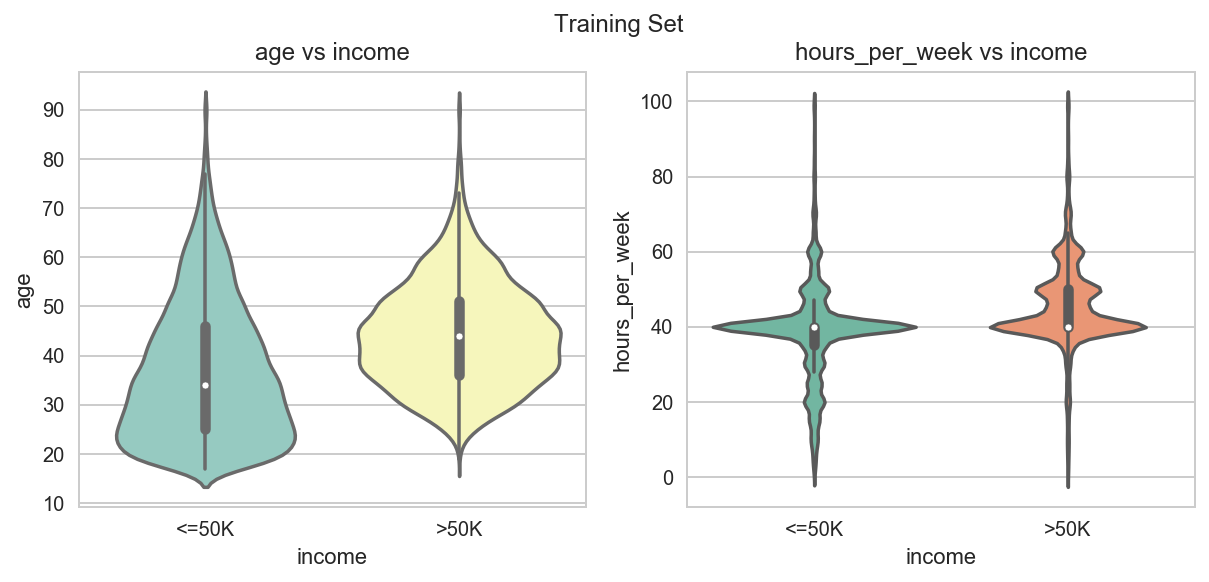

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=False, sharey=False)

sns.violinplot(x='income', y='age', data=train_df.select('age', 'income').toPandas(), ax=axes[0], palette="Set3")
axes[0].set_title('age vs income')

sns.violinplot(x='income', y='hours_per_week', data=train_df.select('hours_per_week', 'income').toPandas(), ax=axes[1], palette="Set2")
axes[1].set_title('hours_per_week vs income')

fig.suptitle('Training Set');

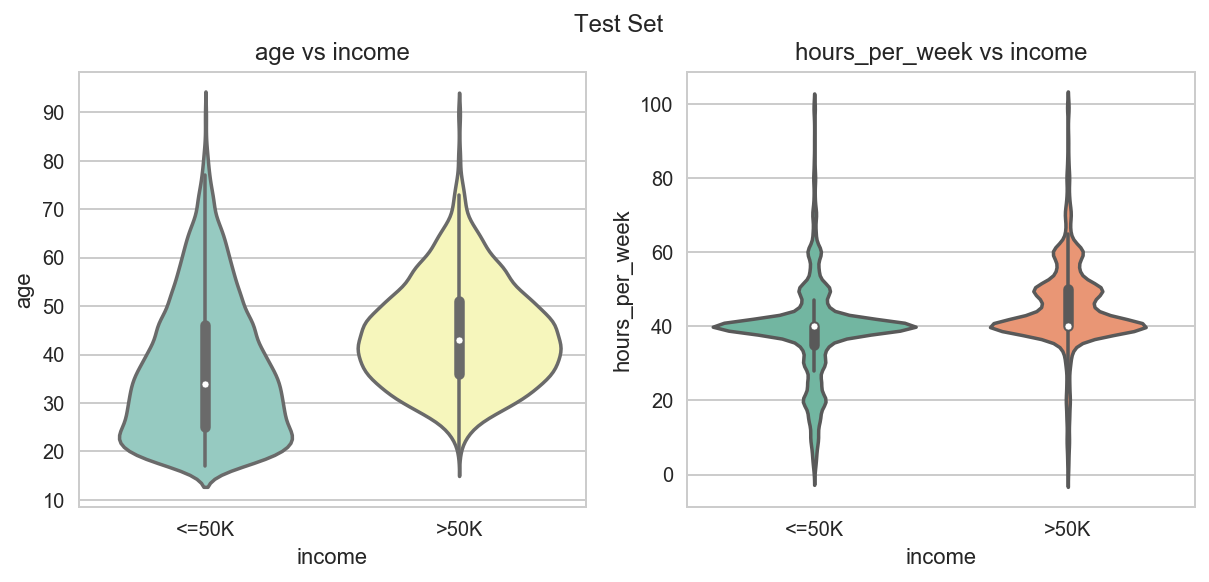

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), sharex=False, sharey=False)

sns.violinplot(x='income', y='age', data=test_df.select('age', 'income').toPandas(), ax=axes[0], palette="Set3")
axes[0].set_title('age vs income')

sns.violinplot(x='income', y='hours_per_week', data=test_df.select('hours_per_week', 'income').toPandas(), ax=axes[1], palette="Set2")
axes[1].set_title('hours_per_week vs income')

fig.suptitle('Test Set');

**How the income is distributed marital_status between the training set and the test set:**

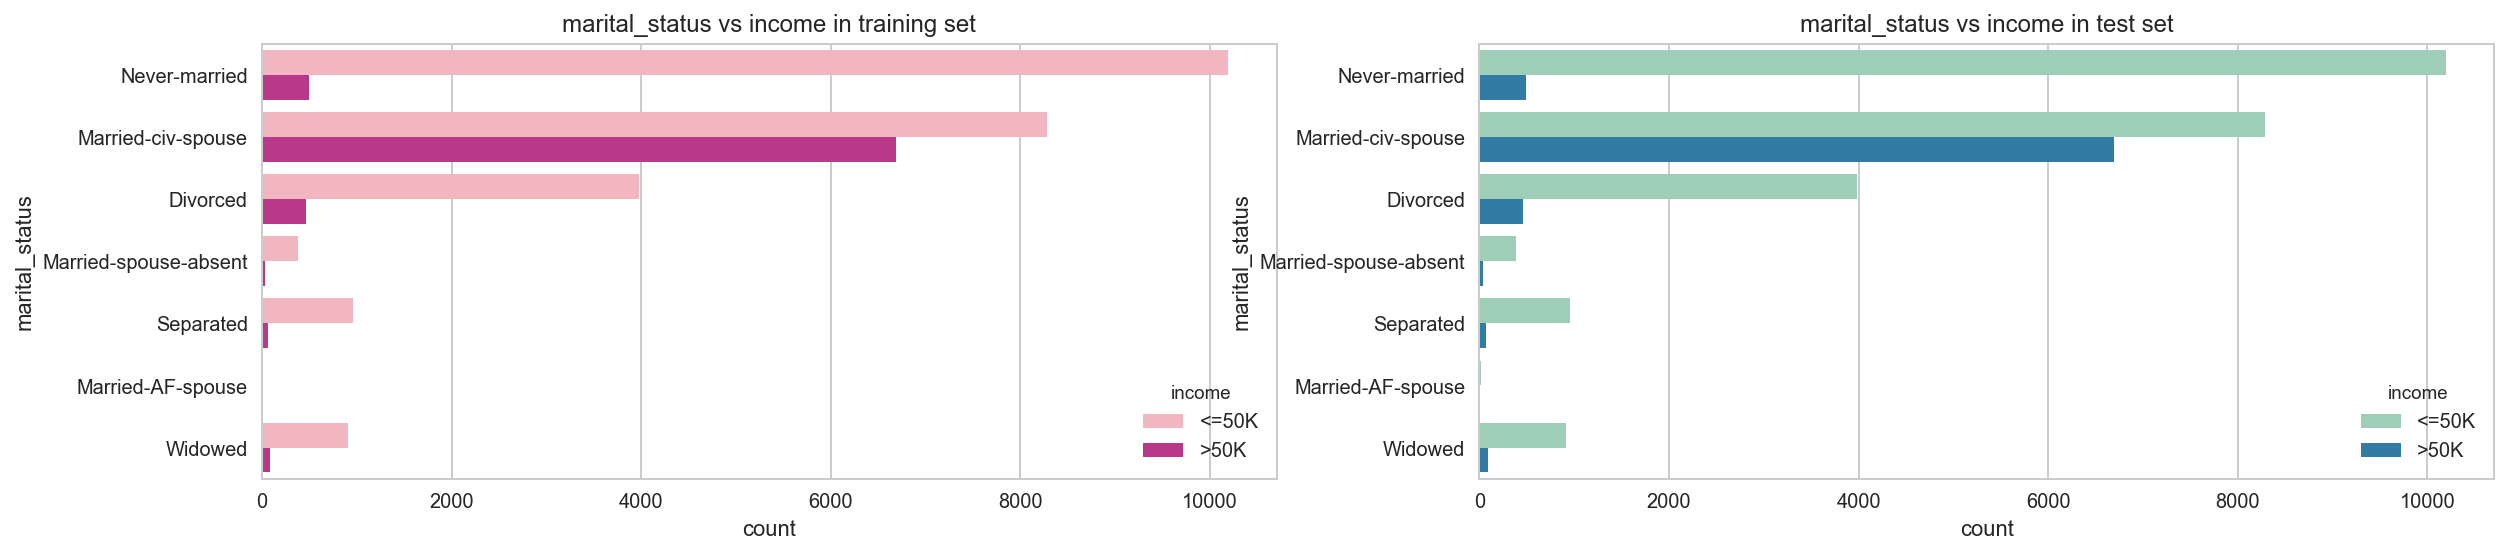

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)

sns.countplot(y='marital_status', hue='income', data=train_df.select('marital_status', 'income').toPandas(), palette="RdPu", ax=axes[0])
axes[0].set_title('marital_status vs income in training set')

sns.countplot(y='marital_status', hue='income', data=train_df.select('marital_status', 'income').toPandas(), palette="YlGnBu", ax=axes[1])
axes[1].set_title('marital_status vs income in test set');

Quite interestingly significant proportion of Married Couples have income >50K. Does it signify joint income?

**How the income is distributed across native_country and education_num between the training set and the test set:**

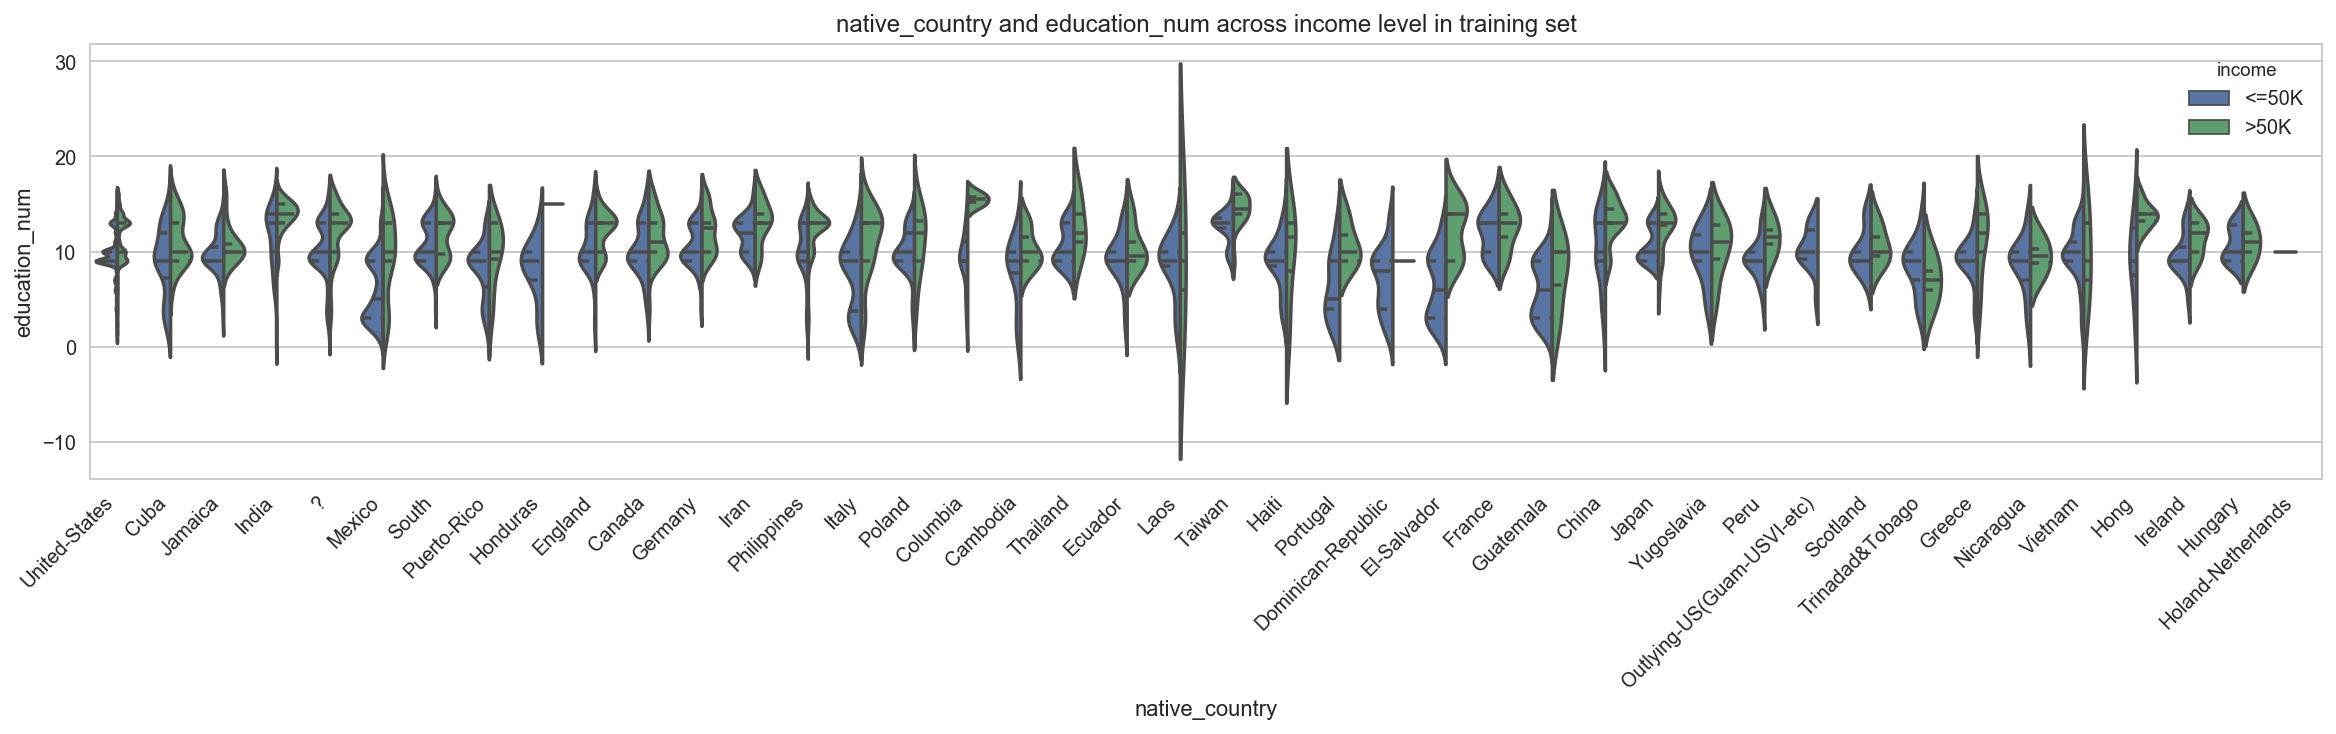

In [24]:
ax = sns.violinplot(x="native_country", y="education_num", hue="income", data=train_df.select('native_country', 'education_num', 'income').toPandas(), inner="quartile", split=True)
plt.title('native_country and education_num across income level in training set')
plt.xticks(rotation=45, ha='right');

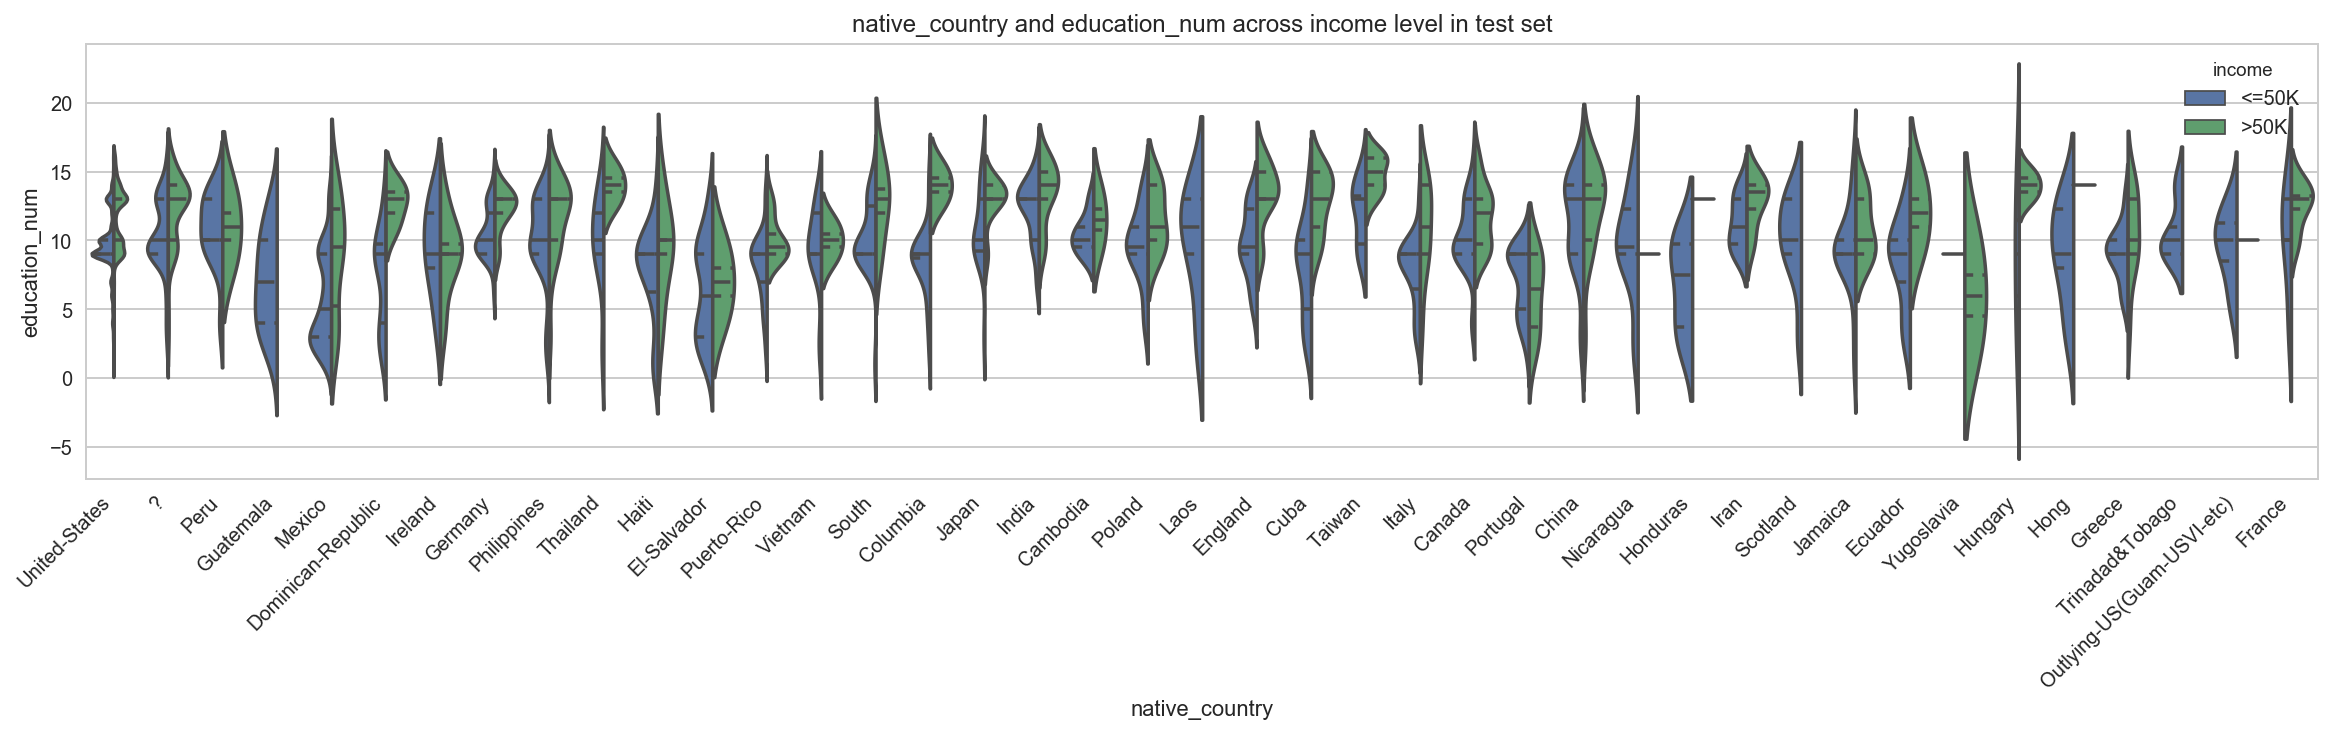

In [25]:
ax = sns.violinplot(x="native_country", y="education_num", hue="income", data=test_df.select('native_country', 'education_num', 'income').toPandas(), inner="quartile", split=True)
plt.title('native_country and education_num across income level in test set')
plt.xticks(rotation=45, ha='right');

Looking at the unique values for the native_country columns we can see there are is **a special charatcer '?'**. It most likely signifies NaN values and we have to handle it later.

**How the income is distributed across workclass and education_num between the training set and the test set:**

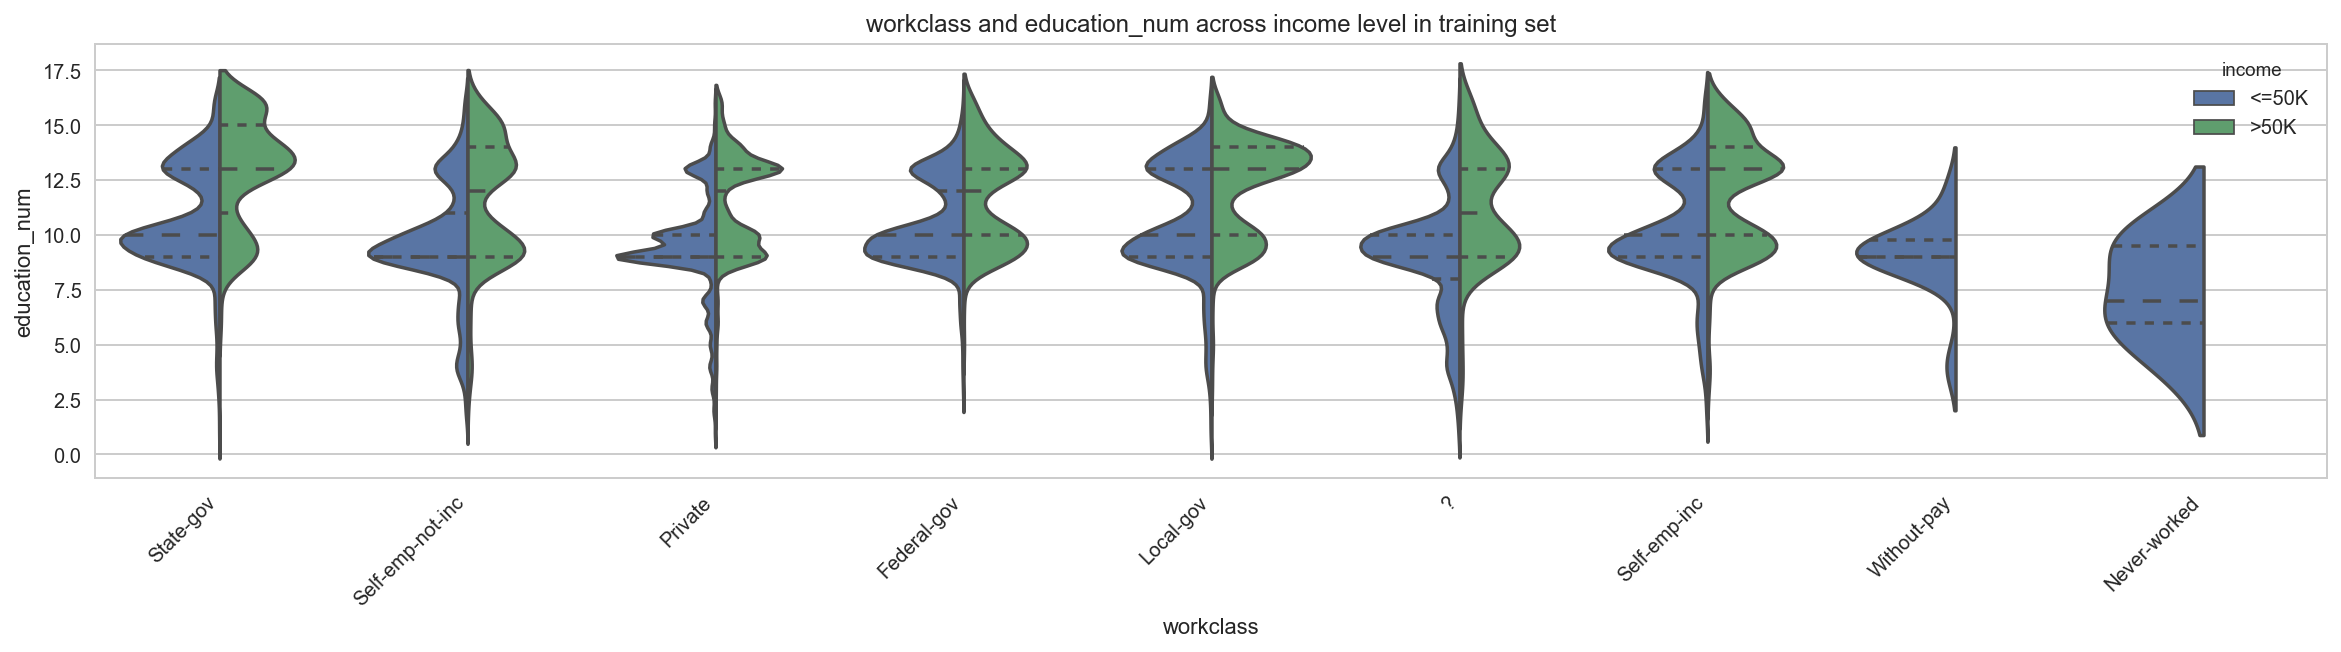

In [26]:
ax = sns.violinplot(x="workclass", y="education_num", hue="income", data=train_df.select('workclass', 'education_num', 'income').toPandas(), inner="quartile", split=True)
plt.title('workclass and education_num across income level in training set')
plt.xticks(rotation=45, ha='right');

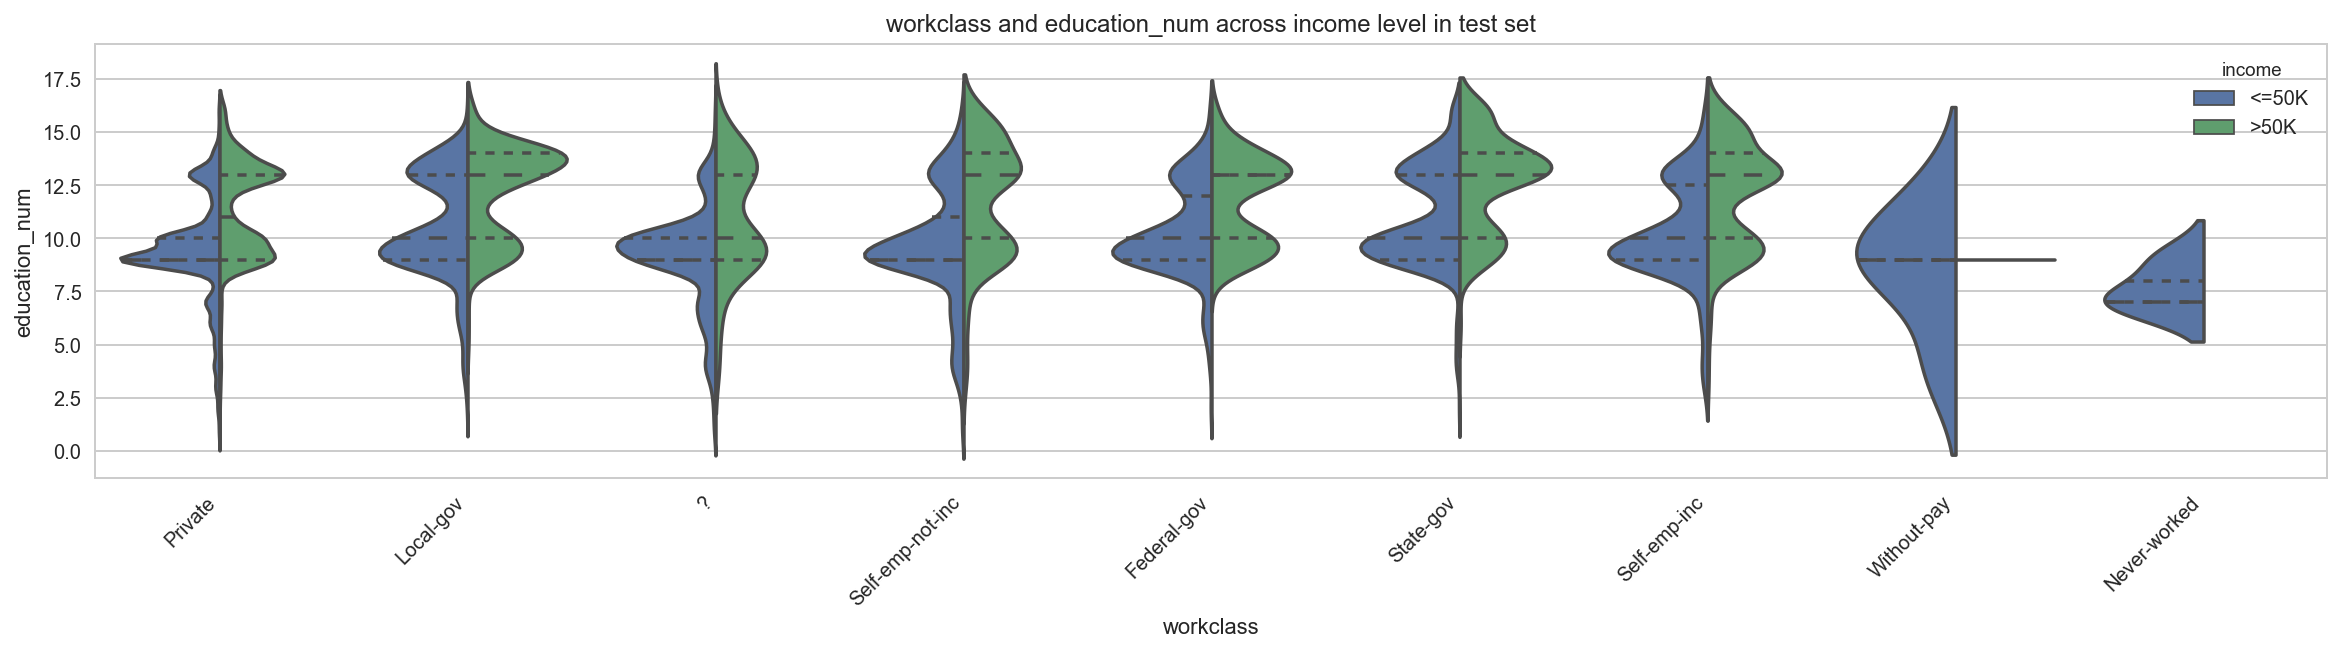

In [27]:
ax = sns.violinplot(x="workclass", y="education_num", hue="income", data=test_df.select('workclass', 'education_num', 'income').toPandas(), inner="quartile", split=True)
plt.title('workclass and education_num across income level in test set')
plt.xticks(rotation=45, ha='right');

**Are educated females earning more than educated males across different workclass in the training set and the test set:**

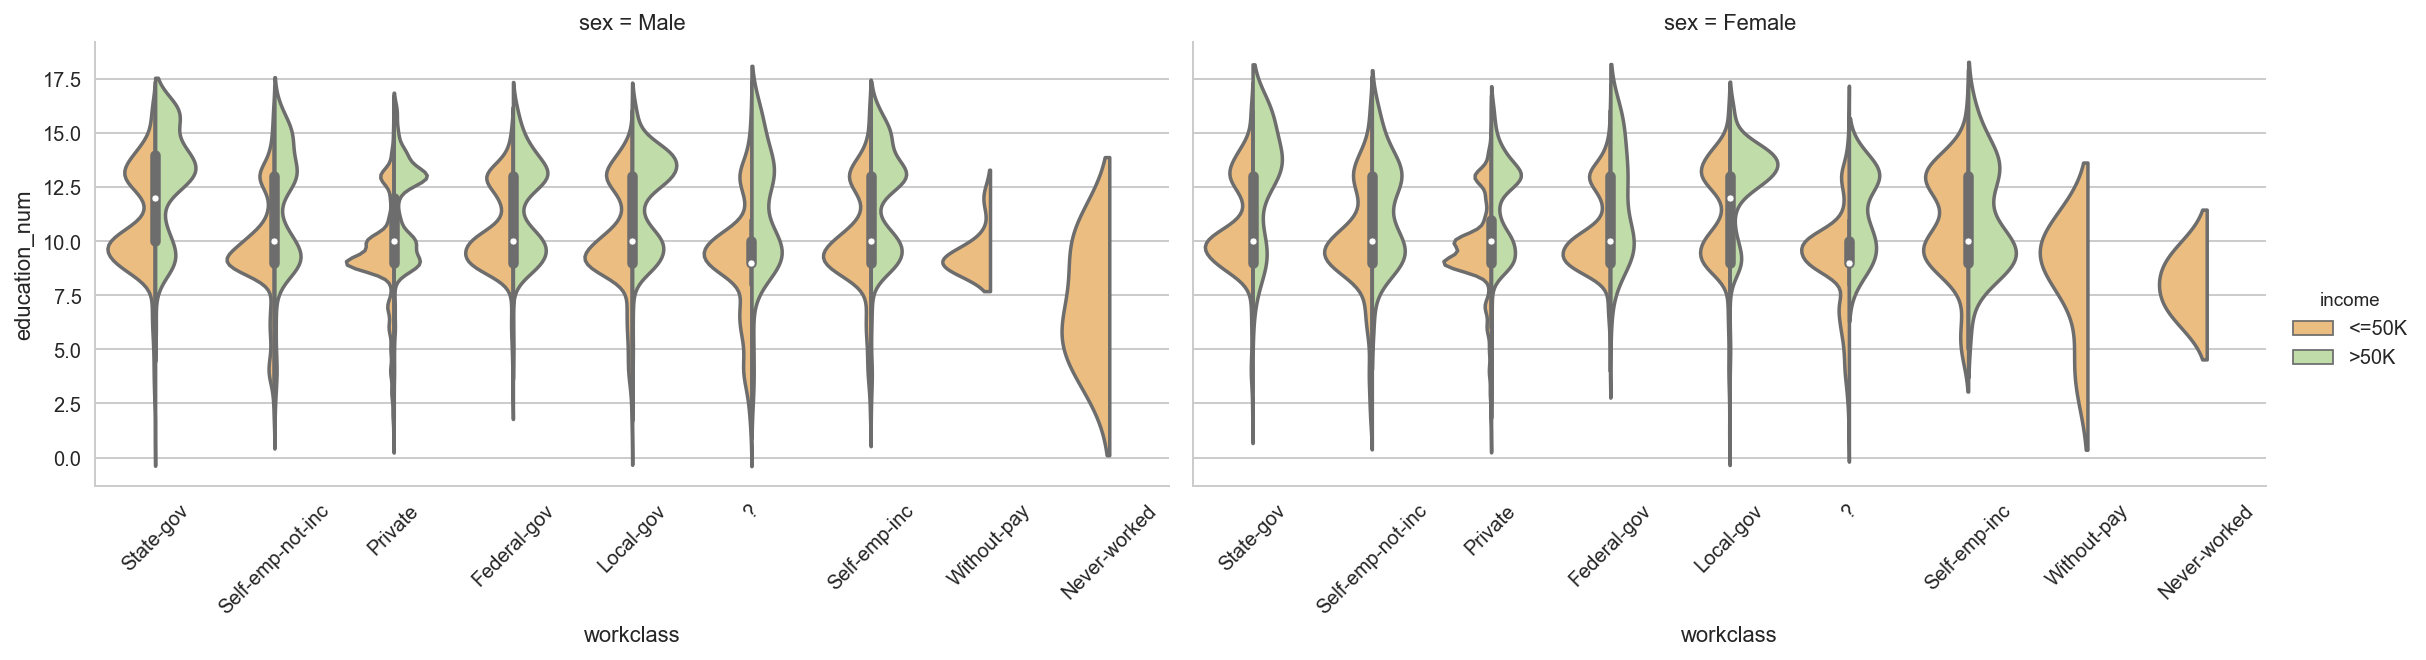

In [28]:
g = sns.factorplot(x="workclass", y="education_num",
                    hue="income", col="sex",
                    data=train_df.select('workclass', 'sex', 'education_num', 'income').toPandas(), kind="violin", split=True,
                   size=4, aspect=2, palette="Spectral")
g.set_xticklabels(rotation=45);

There are more males in Never-worked category than females. Females seem to take up jobs even without-pay rather than sitting idle.

## 3. Data Preprocessing

**sample the training set:**

In [29]:
# sample the training data
train_df.sample(withReplacement=False, fraction=0.01, seed=rnd_seed).limit(10).toPandas()

,age,workclass,fnlgwt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,31,Private,45781.0,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
1,54,?,180211.0,Some-college,10.0,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0.0,0.0,60.0,South,>50K
2,33,Private,185480.0,Bachelors,13.0,Never-married,Prof-specialty,Not-in-family,White,Female,0.0,0.0,45.0,United-States,<=50K
3,22,State-gov,293364.0,Some-college,10.0,Never-married,Protective-serv,Own-child,Black,Female,0.0,0.0,40.0,United-States,<=50K
4,27,Private,163862.0,HS-grad,9.0,Never-married,Transport-moving,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
5,32,Private,84179.0,HS-grad,9.0,Never-married,Handlers-cleaners,Not-in-family,White,Female,0.0,0.0,45.0,United-States,<=50K
6,42,Local-gov,175674.0,9th,5.0,Married-civ-spouse,Other-service,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K
7,19,State-gov,378418.0,HS-grad,9.0,Never-married,Tech-support,Own-child,White,Female,0.0,0.0,40.0,United-States,<=50K
8,22,Private,214399.0,Some-college,10.0,Never-married,Sales,Own-child,White,Female,0.0,0.0,15.0,United-States,<=50K
9,17,Private,316929.0,12th,8.0,Never-married,Handlers-cleaners,Own-child,White,Male,0.0,0.0,20.0,United-States,<=50K


**sample the testing set:**

In [30]:
# sample the test data
test_df.sample(withReplacement=False, fraction=0.01, seed=rnd_seed).limit(10).toPandas()

,age,workclass,fnlgwt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,24,Private,369667.0,Some-college,10.0,Never-married,Other-service,Unmarried,White,Female,0.0,0.0,40.0,United-States,<=50K
1,23,Private,134446.0,HS-grad,9.0,Separated,Machine-op-inspct,Unmarried,Black,Male,0.0,0.0,54.0,United-States,<=50K
2,21,?,65481.0,Some-college,10.0,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K
3,66,Private,275918.0,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,10605.0,0.0,40.0,United-States,>50K
4,22,Private,416165.0,Some-college,10.0,Never-married,Adm-clerical,Own-child,White,Female,0.0,0.0,40.0,United-States,<=50K
5,38,Private,203717.0,Bachelors,13.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,60.0,United-States,<=50K
6,67,State-gov,168224.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,40.0,United-States,<=50K
7,34,?,143582.0,HS-grad,9.0,Married-spouse-absent,?,Not-in-family,Asian-Pac-Islander,Female,0.0,0.0,37.0,Taiwan,<=50K
8,56,Self-emp-not-inc,174564.0,Masters,14.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,60.0,United-States,>50K
9,24,Private,311311.0,Bachelors,13.0,Never-married,Sales,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K


> *We can see some rows have **'?'** which are missing values*

### 3.1 Variance of Values - How many unique values per attribute:

In [31]:
train_df.select([F.countDistinct(col(c)).alias(c) for c in train_df.columns]).toPandas()

,age,workclass,fnlgwt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,73,9,21648,16,16,7,15,6,5,2,119,92,94,42,2


In [32]:
test_df.select([F.countDistinct(col(c)).alias(c) for c in test_df.columns]).toPandas()

,age,workclass,fnlgwt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,73,9,12787,16,16,7,15,6,5,2,113,82,89,41,2


We see 4 unique values for income level because of the typo in test set. None of the attributes show anomalous small set of unique values. It seems reasobale count of unique values for each feature.

### 3.2 How many missing values per attribute:

In [33]:
# count how many missing values per column
train_df.select([F.count(F.when(col(c).contains('?'), c)).alias(c) for c in train_df.columns]).toPandas()
#train_df.select([F.count(F.when(F.isnan(c) | col(c).isNull(), c)).alias(c) for c in train_df.columns]).toPandas()

,age,workclass,fnlgwt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,0,1836,0,0,0,0,1843,0,0,0,0,0,0,583,0


In [34]:
# count how many missing values per column
test_df.select([F.count(F.when(col(c).contains('?'), c)).alias(c) for c in test_df.columns]).toPandas()
#test_df.select([F.count(F.when(F.isnan(c) | col(c).isNull(), c)).alias(c) for c in test_df.columns]).toPandas()

,age,workclass,fnlgwt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,0,963,0,0,0,0,966,0,0,0,0,0,0,274,0


In [35]:
# There are significant missing values and we need to come up with a smart strategy for that, skipping the records for now
#adult_union_df = (adult_union_df
#                  .filter(~col('workclass').contains('?') 
#                          & ~col('occupation').contains('?')
#                          & ~col('native_country').contains('?'))
#                  .cache())

**Filling the missing values:**
    
There are significant missing values and we need to come up with a smart strategy for that, treating them as an `unknown` category for now. Filling up with most frequent item in each attribute does not seem to be a valid choice for me especially for the `native_country` column.

In [36]:
train_df = train_df.replace(to_replace='?', value='unknown', subset=['workclass', 'occupation', 'native_country'])

In [37]:
test_df = test_df.replace(to_replace='?', value='unknown', subset=['workclass', 'occupation', 'native_country'])

In [38]:
# re-check all missing values have been handled
(train_df
 .filter(col('workclass').contains('?'))
 .filter(col('occupation').contains('?'))
 .filter(col('native_country').contains('?'))
).count()

0

**Devise a better Strategy for Missing Values (TODO Later):**

In [39]:
# Find the most frequent workclass
#adult_train_df.groupBy('workclass').count().orderBy('count', ascending=False).select('workclass').first()['workclass']

In [40]:
# Find the most frequent occupation
#adult_train_df.groupBy('occupation').count().orderBy('count', ascending=False).select('occupation').first()['occupation']

In [41]:
# Find the most frequent native_country
#adult_train_df.groupBy('native_country').count().orderBy('count', ascending=False).select('native_country').first()['native_country']

In [42]:
# Imputer Strategy, replace by the maximum value
#adult_union_df = adult_union_df.replace(to_replace=["?"], value=["Private"], subset=["workclass"])
#adult_union_df = adult_union_df.replace(to_replace=["?"], value=["Prof-specialty"], subset=["occupation"])
#adult_union_df = adult_union_df.replace(to_replace=["?"], value=["United-States"], subset=["native_country"])

### 3.4 Featurization: 

**Check Workclass:**

In [43]:
train_df.select(["workclass"]).distinct().show()

+----------------+
|       workclass|
+----------------+
|Self-emp-not-inc|
|         unknown|
|       Local-gov|
|       State-gov|
|         Private|
|     Without-pay|
|     Federal-gov|
|    Never-worked|
|    Self-emp-inc|
+----------------+



**Check Education & Education Num:**

In [44]:
# check the Education and Education Num 
train_df.select(["education", "education_num"]).distinct().show()

+------------+-------------+
|   education|education_num|
+------------+-------------+
|   Preschool|          1.0|
|         9th|          5.0|
|   Assoc-voc|         11.0|
|   Bachelors|         13.0|
|     1st-4th|          2.0|
|     7th-8th|          4.0|
|        12th|          8.0|
|     5th-6th|          3.0|
|   Doctorate|         16.0|
| Prof-school|         15.0|
|  Assoc-acdm|         12.0|
|     Masters|         14.0|
|        11th|          7.0|
|     HS-grad|          9.0|
|Some-college|         10.0|
|        10th|          6.0|
+------------+-------------+



There is a one-to-one mapping between Education and Education Num. We will drop Education.

In [45]:
train_df = train_df.drop('education')
test_df = test_df.drop('education')

**Marital Status:**

In [46]:
train_df.select(["marital_status"]).distinct().show(truncate=False)

+---------------------+
|marital_status       |
+---------------------+
|Separated            |
|Never-married        |
|Married-spouse-absent|
|Divorced             |
|Widowed              |
|Married-AF-spouse    |
|Married-civ-spouse   |
+---------------------+



**Occupation:**

In [47]:
train_df.select(["occupation"]).distinct().show()

+-----------------+
|       occupation|
+-----------------+
|            Sales|
|  Exec-managerial|
|   Prof-specialty|
|Handlers-cleaners|
|          unknown|
|  Farming-fishing|
|     Craft-repair|
| Transport-moving|
|  Priv-house-serv|
|  Protective-serv|
|    Other-service|
|     Tech-support|
|Machine-op-inspct|
|     Armed-Forces|
|     Adm-clerical|
+-----------------+



**Relationship:**

In [48]:
train_df.select(["relationship"]).distinct().show()

+--------------+
|  relationship|
+--------------+
|     Own-child|
| Not-in-family|
|     Unmarried|
|          Wife|
|Other-relative|
|       Husband|
+--------------+



**Check Race:**

In [49]:
train_df.select(["race"]).distinct().show()

+------------------+
|              race|
+------------------+
|             Other|
|Amer-Indian-Eskimo|
|             White|
|Asian-Pac-Islander|
|             Black|
+------------------+



**Sex:**

In [50]:
train_df.select(["sex"]).distinct().show()

+------+
|   sex|
+------+
|Female|
|  Male|
+------+



**Native Country:**

In [51]:
train_df.select(["native_country"]).distinct().show()

+------------------+
|    native_country|
+------------------+
|       Philippines|
|           Germany|
|          Cambodia|
|            France|
|            Greece|
|           unknown|
|            Taiwan|
|           Ecuador|
|         Nicaragua|
|              Hong|
|              Peru|
|             India|
|             China|
|             Italy|
|Holand-Netherlands|
|              Cuba|
|             South|
|              Iran|
|           Ireland|
|          Thailand|
+------------------+
only showing top 20 rows



## 4. Preparing Features for Machine Learning

We will build a logistic regression to predict the label of income based on the following features:

+ Label: 
    - <=50K = 0
    - \>50K = 1
+ Features -> {age, workclass, education_num, marital_status, occupation, relationship, race, sex, capital_gain, capital_loss, hours_per_week, native_country}

In order for the features to be used by a machine learning algorithm, they must be transformed and put into feature vectors, which are vectors of numbers representing the value for each feature.

### Using the Spark ML Package

The [ML package](http://spark.apache.org/docs/latest/ml-guide.html) is the newer library of machine learning routines. [Spark ML provides a uniform set of high-level APIs built on top of DataFrames](http://spark.apache.org/docs/latest/ml-pipeline.html#pipeline-components).

![](assets/ml-pipeline.png)

Image: https://mapr.com/blog/fast-data-processing-pipeline-predicting-flight-delays-using-apache-apis-pt-1/

We will use an ML Pipeline to pass the data through transformers in order to extract the features and an estimator to produce the model.

- Transformer: A Transformer is an algorithm which transforms one DataFrame into another DataFrame. We will use a transformer to get a DataFrame with a features vector column.
- Estimator: An Estimator is an algorithm which can be fit on a DataFrame to produce a Transformer. We will use a an estimator to train a model which can transform data to get predictions.
- Pipeline: A Pipeline chains multiple Transformers and Estimators together to specify a ML workflow.

## Feature Extraction and Pipelining

The ML package needs the label and feature vector to be added as columns to the input dataframe. We set up a pipeline to pass the data through transformers in order to extract the features and label. We use a StringIndexer to encode a string columns to a column of number indices. We use a OneHotEncoder to map a number indices column to a column of binary vectors, with at most a single one-value. Encoding categorical features allows machine learning algorithms to treat categorical features appropriately, improving performance. An example of StringIndexing and OneHotEncoding for 'race' is shown below:

![](assets/example-category-encoding.png)

### 6.1 Use a combination of StringIndexer and OneHotEncoder to encode Categorical columns:

**Experiment: Let's SringIndex the 'race' column:**

In [52]:
col_name = "race"

In [53]:
race_indexer_model = StringIndexer(inputCol=col_name, outputCol="{0}_indexed".format(col_name)).fit(train_df)
race_indexed_df = race_indexer_model.transform(train_df)

In [54]:
# check the encoded carrier values
race_indexer_model.labels

['White', 'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other']

In [55]:
# check the race code and index mapping 
race_indexed_df.select(['race', 'race_indexed']).distinct().show()

+------------------+------------+
|              race|race_indexed|
+------------------+------------+
|             Other|         4.0|
|             Black|         1.0|
|Amer-Indian-Eskimo|         3.0|
|Asian-Pac-Islander|         2.0|
|             White|         0.0|
+------------------+------------+



**Experiment: Let's OneHotEncode the 'race' column:**

`pyspark.ml.feature.OneHotEncoder` maps a column of category indices to a column of binary vectors, with at most a single one-value per row that indicates the input category index. For example with 5 categories, an input value of 2.0 would map to an output vector of [0.0, 0.0, 1.0, 0.0]. The last category is not included by default (configurable via dropLast=True) because it makes the vector entries sum up to one, and hence linearly dependent. So an input value of 4.0 maps to [0.0, 0.0, 0.0, 0.0]. Note that this is different from scikit-learn's OneHotEncoder, which keeps all categories. The output vectors are sparse. However, if we configure dropLast=False, then with 5 categories, an input value of 2.0 would map to an output vector of [0.0, 0.0, 1.0, 0.0, 0.0].

In [56]:
race_encoder = OneHotEncoder(inputCol="{0}_indexed".format(col_name), outputCol="{0}_encoded".format(col_name), dropLast=False)
race_encoded_df = race_encoder.transform(race_indexed_df)

In [57]:
race_encoded_df.select('age', 'marital_status', 'race', 'race_indexed', 'race_encoded', 'income').limit(10).show()

+---+--------------------+-----+------------+-------------+------+
|age|      marital_status| race|race_indexed| race_encoded|income|
+---+--------------------+-----+------------+-------------+------+
| 39|       Never-married|White|         0.0|(5,[0],[1.0])| <=50K|
| 50|  Married-civ-spouse|White|         0.0|(5,[0],[1.0])| <=50K|
| 38|            Divorced|White|         0.0|(5,[0],[1.0])| <=50K|
| 53|  Married-civ-spouse|Black|         1.0|(5,[1],[1.0])| <=50K|
| 28|  Married-civ-spouse|Black|         1.0|(5,[1],[1.0])| <=50K|
| 37|  Married-civ-spouse|White|         0.0|(5,[0],[1.0])| <=50K|
| 49|Married-spouse-ab...|Black|         1.0|(5,[1],[1.0])| <=50K|
| 52|  Married-civ-spouse|White|         0.0|(5,[0],[1.0])|  >50K|
| 31|       Never-married|White|         0.0|(5,[0],[1.0])|  >50K|
| 42|  Married-civ-spouse|White|         0.0|(5,[0],[1.0])|  >50K|
+---+--------------------+-----+------------+-------------+------+



Note: The column vector is a SparseVector: (5,[0],[1.0]) means there are 5 elements and the 0th position has a 1.0.

### 6.2 Combine StringIndexer, OneHotEncoder, StandardScaler, VectorAssembler put features into a feature vector column:

In [58]:
assembled_train_df = train_df
assembled_test_df = test_df

**OneHotEncode all categorical columns:**

In [59]:
# categorical columns
categorical_columns = ["workclass", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]
# numerial columns
numerical_columns = ["age", "education_num", "capital_gain", "capital_loss", "hours_per_week"]

In [60]:
string_indexer_models = []
one_hot_encoders = []
for col_name in categorical_columns:
    # String Indexers will encode string categorical columns into a column of numeric indices
    string_indexer_model = StringIndexer(inputCol=col_name, outputCol="{0}_indexed".format(col_name)).fit(assembled_train_df)
    assembled_train_df = string_indexer_model.transform(assembled_train_df)
    assembled_test_df = string_indexer_model.transform(assembled_test_df)
    
    string_indexer_models.append(string_indexer_model)
    
    # OneHotEncoders map number indices column to column of binary vectors
    one_hot_encoder = OneHotEncoder(inputCol="{0}_indexed".format(col_name), outputCol="{0}_encoded".format(col_name), dropLast=False)
    assembled_train_df = one_hot_encoder.transform(assembled_train_df)
    assembled_test_df = one_hot_encoder.transform(assembled_test_df)
    
    one_hot_encoders.append(one_hot_encoder)

In [61]:
assembled_train_df.select('age', 'marital_status_indexed', 'marital_status_encoded', 'race_indexed', 'race_encoded', 'income').limit(10).show()

+---+----------------------+----------------------+------------+-------------+------+
|age|marital_status_indexed|marital_status_encoded|race_indexed| race_encoded|income|
+---+----------------------+----------------------+------------+-------------+------+
| 39|                   1.0|         (7,[1],[1.0])|         0.0|(5,[0],[1.0])| <=50K|
| 50|                   0.0|         (7,[0],[1.0])|         0.0|(5,[0],[1.0])| <=50K|
| 38|                   2.0|         (7,[2],[1.0])|         0.0|(5,[0],[1.0])| <=50K|
| 53|                   0.0|         (7,[0],[1.0])|         1.0|(5,[1],[1.0])| <=50K|
| 28|                   0.0|         (7,[0],[1.0])|         1.0|(5,[1],[1.0])| <=50K|
| 37|                   0.0|         (7,[0],[1.0])|         0.0|(5,[0],[1.0])| <=50K|
| 49|                   5.0|         (7,[5],[1.0])|         1.0|(5,[1],[1.0])| <=50K|
| 52|                   0.0|         (7,[0],[1.0])|         0.0|(5,[0],[1.0])|  >50K|
| 31|                   1.0|         (7,[1],[1.0])|   

**StandardScale all numerical columns:**

Standardize all the numerical columns of the Spark Dataframe. `StandardScaler` expects all the numerical columns in a vectorised form. Hence we need a `VectorAssembler` to transform all the numerical features into a Vectorized feature column.

In [62]:
# Vectorize the numerical features first
scaler_vector_assembler = VectorAssembler(inputCols=numerical_columns, outputCol="numerical_features")

In [63]:
assembled_train_df = scaler_vector_assembler.transform(assembled_train_df)
assembled_test_df = scaler_vector_assembler.transform(assembled_test_df)

In [64]:
assembled_train_df.select('numerical_features', 'marital_status_encoded', 'race_encoded', 'income').limit(10).show(truncate=False)

+----------------------------+----------------------+-------------+------+
|numerical_features          |marital_status_encoded|race_encoded |income|
+----------------------------+----------------------+-------------+------+
|[39.0,13.0,2174.0,0.0,40.0] |(7,[1],[1.0])         |(5,[0],[1.0])|<=50K |
|[50.0,13.0,0.0,0.0,13.0]    |(7,[0],[1.0])         |(5,[0],[1.0])|<=50K |
|[38.0,9.0,0.0,0.0,40.0]     |(7,[2],[1.0])         |(5,[0],[1.0])|<=50K |
|[53.0,7.0,0.0,0.0,40.0]     |(7,[0],[1.0])         |(5,[1],[1.0])|<=50K |
|[28.0,13.0,0.0,0.0,40.0]    |(7,[0],[1.0])         |(5,[1],[1.0])|<=50K |
|[37.0,14.0,0.0,0.0,40.0]    |(7,[0],[1.0])         |(5,[0],[1.0])|<=50K |
|[49.0,5.0,0.0,0.0,16.0]     |(7,[5],[1.0])         |(5,[1],[1.0])|<=50K |
|[52.0,9.0,0.0,0.0,45.0]     |(7,[0],[1.0])         |(5,[0],[1.0])|>50K  |
|[31.0,14.0,14084.0,0.0,50.0]|(7,[1],[1.0])         |(5,[0],[1.0])|>50K  |
|[42.0,13.0,5178.0,0.0,40.0] |(7,[0],[1.0])         |(5,[0],[1.0])|>50K  |
+------------------------

Observe how all the numerical features have been clubbed as vectors into a single column.

In [65]:
# create StandardScalerModel
standard_scaler_model = StandardScaler(withMean=True, inputCol='numerical_features', outputCol='numerical_features_scaled').fit(assembled_train_df)

In [66]:
# apply StandardScaler
assembled_train_df = standard_scaler_model.transform(assembled_train_df)
assembled_test_df = standard_scaler_model.transform(assembled_test_df)

In [67]:
assembled_train_df.select('numerical_features_scaled', 'marital_status_encoded', 'race_encoded', 'income').limit(10).toPandas()

,numerical_features_scaled,marital_status_encoded,race_encoded,income
0,"[0.03067008638, 1.13472133885, 0.148450615588, -0.216656200028, -0.0354289029213]","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)",<=50K
1,"[0.837096125788, 1.13472133885, -0.145918242817, -0.216656200028, -2.22211899816]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)",<=50K
2,"[-0.042641371748, -0.420053173618, -0.145918242817, -0.216656200028, -0.0354289029213]","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)",<=50K
3,"[1.05703050017, -1.19744042985, -0.145918242817, -0.216656200028, -0.0354289029213]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0)",<=50K
4,"[-0.775755953028, 1.13472133885, -0.145918242817, -0.216656200028, -0.0354289029213]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0)",<=50K
5,"[-0.115952829876, 1.52341496696, -0.145918242817, -0.216656200028, -0.0354289029213]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)",<=50K
6,"[0.76378466766, -1.97482768608, -0.145918242817, -0.216656200028, -1.97915343202]","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0)",<=50K
7,"[0.983719042044, -0.420053173618, -0.145918242817, -0.216656200028, 0.369513707308]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)",>50K
8,"[-0.555821578644, 1.52341496696, 1.76111533666, -0.216656200028, 0.774456317537]","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)",>50K
9,"[0.250604460764, 1.13472133885, 0.55520500871, -0.216656200028, -0.0354289029213]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)",>50K


> **Observation:** toPandas() method transforms the Sparse One Hot Encoded Vectors into DenseVectors for display.

**Transform Income attribute into Binary Labels:**

In [68]:
income_indexer_model = StringIndexer(inputCol='income', outputCol='label').fit(assembled_train_df)

In [69]:
income_indexer_model.labels

['<=50K', '>50K']

In [70]:
assembled_train_df = income_indexer_model.transform(assembled_train_df)
assembled_test_df = income_indexer_model.transform(assembled_test_df)

In [71]:
# check the income level and index mapping 
assembled_train_df.select(["income", "label"]).distinct().show()

+------+-----+
|income|label|
+------+-----+
| <=50K|  0.0|
|  >50K|  1.0|
+------+-----+



In [72]:
assembled_train_df.select('numerical_features_scaled', 'marital_status_encoded', 'race_encoded', 'income', 'label').limit(10).toPandas()

,numerical_features_scaled,marital_status_encoded,race_encoded,income,label
0,"[0.03067008638, 1.13472133885, 0.148450615588, -0.216656200028, -0.0354289029213]","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)",<=50K,0.0
1,"[0.837096125788, 1.13472133885, -0.145918242817, -0.216656200028, -2.22211899816]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)",<=50K,0.0
2,"[-0.042641371748, -0.420053173618, -0.145918242817, -0.216656200028, -0.0354289029213]","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)",<=50K,0.0
3,"[1.05703050017, -1.19744042985, -0.145918242817, -0.216656200028, -0.0354289029213]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0)",<=50K,0.0
4,"[-0.775755953028, 1.13472133885, -0.145918242817, -0.216656200028, -0.0354289029213]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0)",<=50K,0.0
5,"[-0.115952829876, 1.52341496696, -0.145918242817, -0.216656200028, -0.0354289029213]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)",<=50K,0.0
6,"[0.76378466766, -1.97482768608, -0.145918242817, -0.216656200028, -1.97915343202]","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0)",<=50K,0.0
7,"[0.983719042044, -0.420053173618, -0.145918242817, -0.216656200028, 0.369513707308]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)",>50K,1.0
8,"[-0.555821578644, 1.52341496696, 1.76111533666, -0.216656200028, 0.774456317537]","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)",>50K,1.0
9,"[0.250604460764, 1.13472133885, 0.55520500871, -0.216656200028, -0.0354289029213]","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)",>50K,1.0


**Assemble transformed features into one Feature Vector for Spark:**

In [73]:
feature_cols = ["{0}_encoded".format(col) for col in categorical_columns] + ['numerical_features_scaled']

In [74]:
feature_cols

['workclass_encoded',
 'marital_status_encoded',
 'occupation_encoded',
 'relationship_encoded',
 'race_encoded',
 'sex_encoded',
 'native_country_encoded',
 'numerical_features_scaled']

In [75]:
# The VectorAssembler combines a given list of columns into a single feature vector column.
feature_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

In [76]:
# cache the dataframe because we would be reusing this again and again
assembled_train_df = feature_assembler.transform(assembled_train_df).cache()
assembled_test_df = feature_assembler.transform(assembled_test_df).cache()

In [77]:
assembled_train_df.columns

['age',
 'workclass',
 'fnlgwt',
 'education_num',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'native_country',
 'income',
 'workclass_indexed',
 'workclass_encoded',
 'marital_status_indexed',
 'marital_status_encoded',
 'occupation_indexed',
 'occupation_encoded',
 'relationship_indexed',
 'relationship_encoded',
 'race_indexed',
 'race_encoded',
 'sex_indexed',
 'sex_encoded',
 'native_country_indexed',
 'native_country_encoded',
 'numerical_features',
 'numerical_features_scaled',
 'label',
 'features']

**Result: SparseVector representation of the Feature Vectors**

In [78]:
assembled_train_df.select('features', 'label').limit(5).show(10,110)

+--------------------------------------------------------------------------------------------------------------+-----+
|                                                                                                      features|label|
+--------------------------------------------------------------------------------------------------------------+-----+
|(91,[4,10,19,32,37,42,44,86,87,88,89,90],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.03067008637999638,1.134721338847922...|  0.0|
|(91,[1,9,18,31,37,42,44,86,87,88,89,90],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.8370961257882483,1.1347213388479223,...|  0.0|
|(91,[0,11,25,32,37,42,44,86,87,88,89,90],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.04264137174802653,-0.4200531736175...|  0.0|
|(91,[0,9,25,31,38,42,44,86,87,88,89,90],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.057030500172317,-1.197440429850231,-...|  0.0|
|(91,[0,9,16,35,38,43,53,86,87,88,89,90],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.7757559530282556,1.1347213388479223...|  0.0|
+-----------------------------------------------

## 7. Stratified Sampling

In order to ensure that our model is sensitive to the income levels, we can put the two sample types on the same footing using stratified sampling. The DataFrames `sampleBy()` function does this when provided with fractions of each sample type to be returned.

We will split the training set into training and validation set in the ratio 0.75:0.25.

In [79]:
assembled_train_df.groupBy('income').count().withColumn('%age', F.round(col('count') / assembled_train_df.count(), 2)).toPandas()

,income,count,%age
0,<=50K,24720,0.76
1,>50K,7841,0.24


In [80]:
# specify the exact fraction desired from each key as a dictionary
fractions = {0.0: 0.25, 1.0: 0.25}

In [81]:
# create the validation set with 25% of the entire data and same distribution of income levels
assembled_validation_df = assembled_train_df.stat.sampleBy('label', fractions, seed=rnd_seed).cache()

In [82]:
# subtract the validation set from the original training set to get 75% of the entire data and same distribution of income levels
assembled_train_df = assembled_train_df.subtract(assembled_validation_df).cache()

**Recheck the distribution:**

Check whether the training and validation set contain rows across are represented in the same proportion of income levels.

In [83]:
assembled_train_df.groupBy('income').count().withColumn('%age', F.round(col('count') / assembled_train_df.count(), 2)).show()

+------+-----+----+
|income|count|%age|
+------+-----+----+
| <=50K|18538|0.76|
|  >50K| 5882|0.24|
+------+-----+----+



In [84]:
assembled_validation_df.groupBy('income').count().withColumn('%age', F.round(col('count') / assembled_validation_df.count(), 2)).show()

+------+-----+----+
|income|count|%age|
+------+-----+----+
| <=50K| 6161|0.76|
|  >50K| 1957|0.24|
+------+-----+----+



## 8. Train a Logistic Regression

In [85]:
log_reg = LogisticRegression(featuresCol='features', labelCol='label', maxIter=20, family='auto')

In [86]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='label', metricName='areaUnderROC')

In [87]:
model = log_reg.fit(assembled_train_df)

In [88]:
train_preds = model.transform(assembled_validation_df)

In [89]:
print(train_preds.columns)

['age', 'workclass', 'fnlgwt', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income', 'workclass_indexed', 'workclass_encoded', 'marital_status_indexed', 'marital_status_encoded', 'occupation_indexed', 'occupation_encoded', 'relationship_indexed', 'relationship_encoded', 'race_indexed', 'race_encoded', 'sex_indexed', 'sex_encoded', 'native_country_indexed', 'native_country_encoded', 'numerical_features', 'numerical_features_scaled', 'label', 'features', 'rawPrediction', 'probability', 'prediction']


In [90]:
train_areaUnderROC = evaluator.evaluate(train_preds)
train_areaUnderROC

0.9079615233443189

In [91]:
trainpredlbls = train_preds.select("prediction", "label").cache()

In [92]:
trainpredlbls.show(10)

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
|       0.0|  0.0|
|       1.0|  0.0|
|       0.0|  1.0|
|       1.0|  1.0|
|       1.0|  1.0|
|       0.0|  0.0|
|       0.0|  1.0|
|       1.0|  0.0|
|       0.0|  0.0|
+----------+-----+
only showing top 10 rows



**Training Accuracy:**

In [93]:
def accuracy(predlbls):
    counttotal = predlbls.count()
    correct = predlbls.filter(col('label') == col("prediction")).count()
    wrong = predlbls.filter(col('Label') != col("prediction")).count()
    ratioCorrect = float(correct)/counttotal
    print("Correct: {0}, Wrong: {1}, Model Accuracy: {2}".format(correct, wrong, np.round(ratioCorrect, 2)))

In [94]:
accuracy(trainpredlbls)

Correct: 6898, Wrong: 1220, Model Accuracy: 0.85


**Training & Validation Accuracy: Using Spark 2.3.0 enhancements:**

Spark 2.3.0 has introdcued several new methods in `BinaryLogisticRegressionSummary` which we can leverage to get various metrics.

In [95]:
train_summary = model.evaluate(assembled_train_df)
validation_summary = model.evaluate(assembled_validation_df)

In [96]:
type(train_summary), type(validation_summary)

(pyspark.ml.classification.BinaryLogisticRegressionSummary,
 pyspark.ml.classification.BinaryLogisticRegressionSummary)

In [97]:
print('Training Accuracy   :', train_summary.accuracy)
print('Validation Accuracy :', validation_summary.accuracy)

Training Accuracy   : 0.8525798525798526
Validation Accuracy : 0.8497166789849717


In [98]:
train_summary.areaUnderROC
validation_summary.areaUnderROC

0.9078446629874719

0.9078434599032585

In [99]:
validation_summary.fMeasureByLabel(beta=1.0)

[0.9032513877874703, 0.6635410921125207]

In [100]:
validation_summary.precisionByLabel

[0.8830826484726314, 0.7207908927501497]

In [101]:
validation_summary.recallByLabel

[0.9243629280960883, 0.6147164026571282]

**Null Accuracy:**

Our model should at least perform better than the `Null Accuracy`. It is defined as the accuracy we would have got if we would have blindly predicted the majority class of the training set as the label.

In [102]:
train_total = trainpredlbls.count()

In [103]:
train_label0count = trainpredlbls.filter(col("Label") == 0.0).count()

In [104]:
train_label1count = trainpredlbls.filter(col("label") == 1.0).count()

In [105]:
# If we would have predicted everything to be the majority label then what would have been the accuracy
max(train_label0count, train_label1count) / train_total

0.758930771125893

> Observation: The model accuracy on the training set is 0.85 i.e. it is at least doing better than the NULL accuracy.

**Test Accuracy:**

In [106]:
test_preds = model.transform(assembled_test_df)

In [107]:
test_areaUnderROC = evaluator.evaluate(test_preds)
test_areaUnderROC

0.9034837316291521

In [108]:
testpredlbls = test_preds.select("prediction", "label")

In [109]:
accuracy(testpredlbls)

Correct: 13858, Wrong: 2423, Model Accuracy: 0.85


**Using Spark 2.3.0 enhancements:**

In [110]:
test_summary = model.evaluate(assembled_test_df)

In [111]:
type(test_summary)

pyspark.ml.classification.BinaryLogisticRegressionSummary

In [112]:
test_summary.accuracy

0.8511762176770469

In [113]:
test_summary.areaUnderROC

0.9033016825297057

In [114]:
test_summary.fMeasureByLabel(beta=1.0)

[0.905073457394711, 0.6556771351428164]

In [115]:
test_summary.precisionByLabel

[0.8824293353705118, 0.7229708555311815]

In [116]:
test_summary.recallByLabel

[0.9289103337354242, 0.5998439937597504]

In [117]:
test_summary.roc.show(truncate=False)

+---------------------+-------------------+
|FPR                  |TPR                |
+---------------------+-------------------+
|0.0                  |0.0                |
|8.041817450743868E-5 |0.046801872074883  |
|1.6083634901487736E-4|0.08554342173686948|
|8.845999195818255E-4 |0.12246489859594384|
|0.002010454362685967 |0.1578263130525221 |
|0.003779654201849618 |0.19162766510660426|
|0.005870526739043024 |0.2251690067602704 |
|0.007478890229191798 |0.26053042121684866|
|0.010776035383996784 |0.2909516380655226 |
|0.013751507840772014 |0.3247529901196048 |
|0.017772416566143947 |0.3536141445657826 |
|0.02195416164053076  |0.38169526781071245|
|0.02605548854041013  |0.41003640145605824|
|0.03176517893043828  |0.4344773790951638 |
|0.0365902694008846   |0.4625585023400936 |
|0.04149577804583836  |0.48959958398335934|
|0.047285886610373945 |0.5145605824232969 |
|0.05283474065138721  |0.5374414976599063 |
|0.05798150381986329  |0.5618824752990119 |
|0.06473663047848814  |0.5811232

In [118]:
train_roc_pdf = train_summary.roc.toPandas()
validation_roc_pdf = validation_summary.roc.toPandas()
test_roc_pdf = test_summary.roc.toPandas()

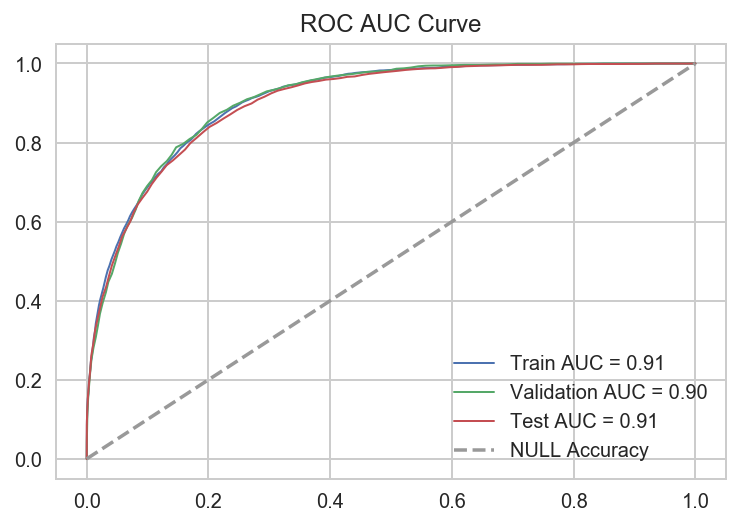

In [119]:
plt.figure(figsize=(6,4))
plt.plot(train_roc_pdf['FPR'], train_roc_pdf['TPR'], lw=1, label='Train AUC = %0.2f' % (train_summary.areaUnderROC))
plt.plot(validation_roc_pdf['FPR'], validation_roc_pdf['TPR'], lw=1, label='Validation AUC = %0.2f' % (test_summary.areaUnderROC))
plt.plot(test_roc_pdf['FPR'], test_roc_pdf['TPR'], lw=1, label='Test AUC = %0.2f' % (validation_summary.areaUnderROC))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.title('ROC AUC Curve')
plt.legend();

## 9. Setup a pipeline with feature transformers and model estimator

Since, we have now trained a model after feature transformation, we are now in a position to set up a pipeline that will call  feature extractors, transformers, assemblers, estimator in a chain  automatically.

In [120]:
# categorical columns
categorical_columns = ["workclass", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]
# numerial columns
numerical_columns = ["age", "education_num", "capital_gain", "capital_loss", "hours_per_week"]

In [121]:
# String Indexers will encode string categorical columns into a column of numeric indices
string_indexers = [StringIndexer(inputCol=col_name, outputCol="{0}_indexed".format(col_name), handleInvalid='skip') for col_name in categorical_columns]

In our training set there is a sigle row where the `native_country` has value 'Holand-Netherlans'. That single will fall into a training or test fold during cross validation leading to Spark throwing an exception saying that it has encountered an unseen value. In order to skip that record during cross-validation we need to configure `handleInvalid='skip'`.

More details here: http://spark.apache.org/docs/2.3.0/api/python/pyspark.ml.html#pyspark.ml.feature.StringIndexer

In [122]:
# OneHotEncoders map number indices column to column of binary vectors
one_hot_encoders = [OneHotEncoder(inputCol="{0}_indexed".format(col_name), outputCol="{0}_encoded".format(col_name), dropLast=False) for col_name in categorical_columns]

In [123]:
scaler_vector_assembler = VectorAssembler(inputCols=numerical_columns, outputCol="numerical_features")

In [124]:
standard_scaler = StandardScaler(withMean=True, inputCol='numerical_features', outputCol='numerical_features_scaled')

In [125]:
income_indexer = StringIndexer(inputCol='income', outputCol='label')

In [126]:
feature_cols = ["{0}_encoded".format(col) for col in categorical_columns] + ['numerical_features_scaled']

In [127]:
feature_cols

['workclass_encoded',
 'marital_status_encoded',
 'occupation_encoded',
 'relationship_encoded',
 'race_encoded',
 'sex_encoded',
 'native_country_encoded',
 'numerical_features_scaled']

In [128]:
# The VectorAssembler combines a given list of columns into a single feature vector column.
feature_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

In [129]:
log_reg = LogisticRegression(featuresCol='features', labelCol='label', maxIter=20, family='binomial')

**Assemble the pipeline:**

In [130]:
steps = string_indexers + one_hot_encoders + [scaler_vector_assembler, standard_scaler, income_indexer, feature_assembler, log_reg]
steps

[StringIndexer_4b10aa0ef59560cd0f23,
 StringIndexer_4776a5d534c3e6398e15,
 StringIndexer_40b4af326038c1e0623e,
 StringIndexer_4b78bee9873f26251100,
 StringIndexer_44acb8700a0241ce3c6a,
 StringIndexer_431da3d56fa011935469,
 StringIndexer_4a71bb1b49db28a7d5c1,
 OneHotEncoder_4cc4928dccdbe8c87283,
 OneHotEncoder_412da75649a883d4d05b,
 OneHotEncoder_4bdd93d8ded4f78c54f9,
 OneHotEncoder_4e88a088e0d566f58239,
 OneHotEncoder_458ab274763429e0fc99,
 OneHotEncoder_426b96ce2a47027e3f37,
 OneHotEncoder_4944b4635b29e27eb111,
 VectorAssembler_4d2299858e316eed4f6a,
 StandardScaler_4688a7162a43f50e130c,
 StringIndexer_4eaf8f1049f7fa4e8de1,
 VectorAssembler_4ae3a14174b4fc0f0f37,
 LogisticRegression_40d7a99f2f793e4ea2d5]

In [131]:
pipeline = Pipeline(stages=steps)

## 10. Set up a CrossValidator with the parameters, a logistic regression estimator and evaluator

A common technique for model selection is `k-fold cross-validation`, where the data is randomly split into `k` partitions. Each partition is used once as the testing dataset, while the rest `k - 1` are used for the training. `k` Models are then generated using the training sets and evaluated with the testing sets, resulting in `k` model performance measurements. 

We can also provide a grid of paramater names and a set of values for each paramater that can be tried to see which set of parameter values of the logistic regression produce the best model. 

Spark ML supports `k-fold cross-validation` with a transformation/estimation pipeline to try out different combinations of parameters, using the `grid search` process. Here, we set up the parameters to test, and a cross-validation evaluator to construct a model selection workflow.

We use a `ParamGridBuilder` to construct the parameter grid. We define an `BinaryClassificationEvaluator`, which will evaluate the model by comparing the test label column with the test prediction column. We use a `CrossValidator` with 5 folds for model selection.

The model parameters leading to the highest performance metric produce the best model.

### 10.1 Set up a CrossValidator with the parameters, a logistic regressor estimator and evaluator

In [132]:
# set param grid to search through logistic regression's regularization parameter for best model
paramGrid = ParamGridBuilder().addGrid(log_reg.regParam, [0.1, 0.01, 0.001]).build()

In [133]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='label', metricName='areaUnderROC')

In [134]:
# Set up 5-fold cross validation with paramGrid
crossVal = CrossValidator(estimator=pipeline, evaluator=evaluator, estimatorParamMaps=paramGrid, numFolds=5)

The CrossValidator uses the Estimator Pipeline, the Parameter Grid, and the Classification Evaluator to fit the training data set and returns a model.

### 10.2 Use CrossValidator Estimator to fit the training data set

In [135]:
cvModel = crossVal.fit(train_df)

The `CrossValidator` uses the `ParamGridBuilder` to iterate through the `regParam` parameter of the logistic regression and evaluate the models, repeating 5 times per parameter value for reliable results.

In [136]:
cvModel.bestModel.stages

[StringIndexer_4b10aa0ef59560cd0f23,
 StringIndexer_4776a5d534c3e6398e15,
 StringIndexer_40b4af326038c1e0623e,
 StringIndexer_4b78bee9873f26251100,
 StringIndexer_44acb8700a0241ce3c6a,
 StringIndexer_431da3d56fa011935469,
 StringIndexer_4a71bb1b49db28a7d5c1,
 OneHotEncoder_4cc4928dccdbe8c87283,
 OneHotEncoder_412da75649a883d4d05b,
 OneHotEncoder_4bdd93d8ded4f78c54f9,
 OneHotEncoder_4e88a088e0d566f58239,
 OneHotEncoder_458ab274763429e0fc99,
 OneHotEncoder_426b96ce2a47027e3f37,
 OneHotEncoder_4944b4635b29e27eb111,
 VectorAssembler_4d2299858e316eed4f6a,
 StandardScaler_4688a7162a43f50e130c,
 StringIndexer_4eaf8f1049f7fa4e8de1,
 VectorAssembler_4ae3a14174b4fc0f0f37,
 LogisticRegression_40d7a99f2f793e4ea2d5]

In [137]:
# the last stage of the best model is the best logistic regressor
cvModel.bestModel.stages[-1]

LogisticRegression_40d7a99f2f793e4ea2d5

### 10.3 Get the best Logistic Regression Model

In [138]:
best_log_reg_model = cvModel.bestModel.stages[-1]
best_log_reg_model

LogisticRegression_40d7a99f2f793e4ea2d5

In [139]:
# Extracts the embedded default param values and user-supplied values and then merges them into a flat param map
# with ordering: default param values < user-supplied values < extra.
best_log_reg_model.extractParamMap()

{Param(parent='LogisticRegression_40d7a99f2f793e4ea2d5', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'binomial',
 Param(parent='LogisticRegression_40d7a99f2f793e4ea2d5', name='predictionCol', doc='prediction column name'): 'prediction',
 Param(parent='LogisticRegression_40d7a99f2f793e4ea2d5', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name'): 'rawPrediction',
 Param(parent='LogisticRegression_40d7a99f2f793e4ea2d5', name='standardization', doc='whether to standardize the training features before fitting the model'): True,
 Param(parent='LogisticRegression_40d7a99f2f793e4ea2d5', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities'): 'probability',
 Param(parent='

In [140]:
# Explains a single param and returns its name, doc, and optional default value and user-supplied value in a string.
for param in ['regParam', 'elasticNetParam', 'maxIter', 'tol']:
    best_log_reg_model.explainParam(param)

'regParam: regularization parameter (>= 0) (default: 0.0, current: 0.001)'

'elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty (default: 0.0)'

'maxIter: maximum number of iterations (>= 0) (default: 100, current: 20)'

'tol: the convergence tolerance for iterative algorithms (>= 0) (default: 1e-06)'

## 11. Evaluate the best Logistic Regression Model

**Training Accuracy - Using Spark 2.3.0 enhancements:**

In [141]:
cv_train_summary = best_log_reg_model.summary

In [142]:
type(cv_train_summary)

pyspark.ml.classification.BinaryLogisticRegressionTrainingSummary

In [143]:
cv_train_summary.accuracy

0.8528300727864623

In [144]:
cv_train_summary.areaUnderROC

0.9078640549695424

In [145]:
cv_train_summary.fMeasureByLabel(beta=1.0)

[0.9057398009363076, 0.6645197423690843]

In [146]:
cv_train_summary.precisionByLabel

[0.881499349107895, 0.7366133788607792]

In [147]:
cv_train_summary.recallByLabel

[0.9313511326860842, 0.6052799387833184]

**Confusion Matrix:**

The Metrics classes have not been ported to `ml` package yet so we have to resort to RDD based `mllib` package.

In [148]:
cv_train_preds = cvModel.transform(train_df)

**Calculate Confusion Matrix Using MulticlassMetrics:**

In [149]:
# we cache the predictions because we will be using it over and over again for several metrics calculation
cv_train_preds_labels = cv_train_preds.select('prediction', 'label').cache()

In [150]:
metrics = MulticlassMetrics(cv_train_preds_labels.rdd)
cv_train_cfm = metrics.confusionMatrix()

In [151]:
cv_train_cfm.toArray().astype(int)

array([[23023,  1697],
       [ 3095,  4746]])

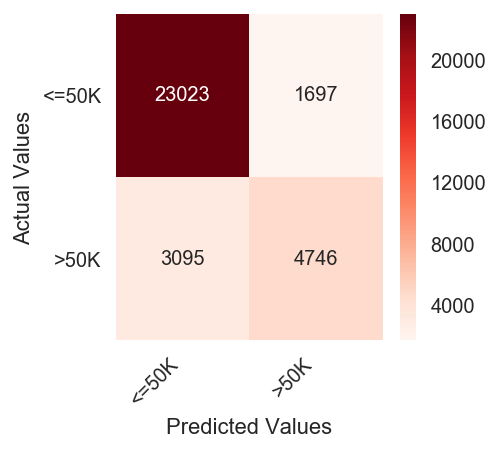

In [152]:
# using seaborn to plot confusion matrix
classes=["<=50K",">50K"]
df_cm = pd.DataFrame(cv_train_cfm.toArray().astype(int), index=classes, columns=classes)
fig = plt.figure(figsize=(3,3))
ax = sns.heatmap(df_cm, annot=True, fmt="d", cmap=plt.cm.Reds)
ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), rotation=0, ha='right')
ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.xlabel('Predicted Values', )
plt.ylabel('Actual Values');

In [153]:
# standard metrics
tn = cv_train_cfm[0, 0]
fp = cv_train_cfm[0, 1]
fn = cv_train_cfm[1, 0]
tp = cv_train_cfm[1, 1]

In [154]:
tn, fp, fn, tp

(23023.0, 1697.0, 3095.0, 4746.0)

We can also calculate the confusion matrix manually and validate our understanding with that values we got from `MulticlassMetrics`.

**Calculate Confusion Matrix Manually:**

Below, we calculate some more metricse and validate our understanding with that values we got from MulticlassMetrics. The number of false/true positive and negative predictions is also useful:

+ True positives are how often the model correctly predicted >50K.
+ False positives are how often the model incorrectly predicted >50K.
+ True negatives indicate how often the model correctly predicted <=50K.
+ False negatives indicate how often the model incorrectly predicted <=50K.

In [155]:
tn = cv_train_preds_labels.filter(col('prediction') == 0.0).filter(col('label') == 0.0).count()

In [156]:
fp = cv_train_preds_labels.filter(col('prediction') == 1.0).filter(col('label') == 0.0).count()

In [157]:
fn = cv_train_preds_labels.filter(col('prediction') == 0.0).filter(col('label') == 1.0).count()

In [158]:
tp = cv_train_preds_labels.filter(col('prediction') == 1.0).filter(col('label') == 1.0).count()

In [159]:
# Revalidate with MulticlassMetrics
tn, fp, fn, tp

(23023, 1697, 3095, 4746)

## 12. Test Predictions & Model Evaluation

The actual performance of the model can be determined using the test data set that has not been used for any training or cross-validation activities.

We transform the test Dataframe with the model pipeline, which will tranform the features according to the pipeline, estimate and then return the label predictions in a column of a new dataframe.

In [160]:
type(cvModel)

pyspark.ml.tuning.CrossValidatorModel

In [161]:
type(cvModel.bestModel)

pyspark.ml.pipeline.PipelineModel

We cannot use something like `test_summary = model.evaluate(test_df)` that we did in section 11 above. `cvModel` is an instance of `pyspark.ml.tuning.CrossValidatorModel` and the `cvModel.bestModel` is a an instance of `pyspark.ml.pipeline.PipelineModel`. They do not have an `evaluate` method. Quite likely so because they are desgined to take an estimator and set of transformation stages; the transformation stages are applied on the raw input and then the estimator is called to evaluate on the transformed features.

In [162]:
type(cvModel.bestModel.stages[-1])

pyspark.ml.classification.LogisticRegressionModel

Although `cvModel.bestModel.stages[-1])` is an instance of `pyspark.ml.classification.LogisticRegressionModel`, we cannot use something like `cvModel.bestModel.stages[-1]).evaluate(test_df)` either because the `test_df` need to be transformed first through the pipeline before it can be evaluated by the `cvModel.bestModel.stages[-1]` or the `LogisticRegressionModel`.

Hence, we have to rely on the `cvModel.transform(test_df)` to generate our test predictions. We will later see another smarter way to generate the test predictions instead of the `cvModel.transform(test_df)`

Once the `CrossValidatorModel` has already been fitted calling the `transform` method on it will call the transformation pipeline internally and finally call the transform method of the `best estimator` which is at the last stage of the pipeline.

### 12.1 Generate Test Predictions:

In [163]:
# Make predictions on test set. cvModel uses the best model found (logregModel).
cv_test_preds = cvModel.transform(test_df)

**Test Accuracy:**

In [164]:
cv_test_areaUnderROC = evaluator.evaluate(cv_test_preds)
cv_test_areaUnderROC

0.9038892934889164

The evaluator will provide us with the score of the predictions. Accuracy is measured by the area under the ROC curve. The area measures the ability of the test to correctly classify true positives from false positives. A random predictor would have .5 accuracy. The closer the value is to 1 the better its predictions are. In this case, the evaluation returns 90% `roc_auc`.

In [165]:
# we cache the predictions because we will be using it over and over again for several metrics calculation
cv_test_preds_labels = cv_test_preds.select('prediction', 'label').cache()

In [166]:
metrics = MulticlassMetrics(cv_test_preds_labels.rdd)
cv_test_cfm = metrics.confusionMatrix()

In [167]:
cv_test_cfm.toArray().astype(int)

array([[11581,   854],
       [ 1544,  2302]])

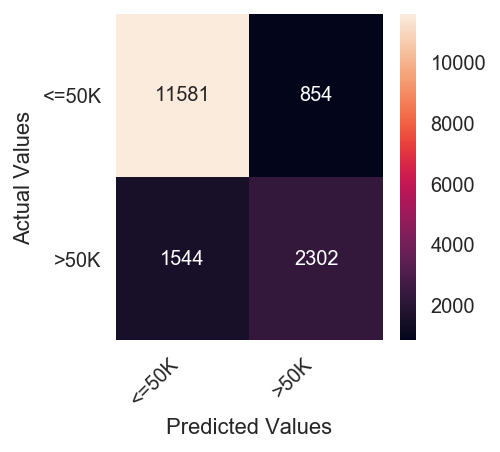

In [168]:
# using seaborn to plot confusion matrix
classes=["<=50K",">50K"]
df_cm = pd.DataFrame(cv_test_cfm.toArray().astype(int), index=classes, columns=classes)
fig = plt.figure(figsize=(3,3))
ax = sns.heatmap(df_cm, annot=True, fmt="d")
ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), rotation=0, ha='right')
ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.xlabel('Predicted Values', )
plt.ylabel('Actual Values');

In [169]:
tn = cv_test_cfm[0, 0]
fp = cv_test_cfm[0, 1]
fn = cv_test_cfm[1, 0]
tp = cv_test_cfm[1, 1]

In [170]:
tn, fp, fn, tp

(11581.0, 854.0, 1544.0, 2302.0)

In [171]:
metrics.accuracy

0.8527117498925127

In [172]:
# Equivalent to Spark 2.3.0 train_summary.fMeasureByLabel(beta=1.0)
[metrics.fMeasure(label=0.0, beta=1.0), metrics.fMeasure(label=1.0, beta=1.0)]

[0.9061815336463225, 0.657526421022565]

In [173]:
# Equivalent to Spark 2.3.0 train_summary.precisionByLabel
[metrics.precision(label=0.0), metrics.precision(label=1.0)]

[0.8823619047619048, 0.729404309252218]

In [174]:
# Equivalent to Spark 2.3.0 train_summary.recallByLabel
[metrics.recall(label=0.0), metrics.recall(label=1.0)]

[0.9313228789706474, 0.5985439417576703]

### 12.1 Creating Partial Pipelines

**Using SMART HACKS:**

Instead of going through the `cvModel.transform(adult_test_df)` and subsequently using the evaluator we can be quite creative and smarter to build a `partialPipeline` using our existing pipeline stages. This is similar to chopping off a chunk of the terminal neural network layers as we do in `transfer learning`.

Here, we create a partialPipeline reusing our all the existing Pipeline stages except the last one i.e. we do not include the final LogisticRegression estimator in the pipeline.

In [175]:
best_log_reg_model = cvModel.bestModel.stages[-1]

In [176]:
type(best_log_reg_model)

pyspark.ml.classification.LogisticRegressionModel

In [177]:
# chop off the estimator from the pipeline
last_stage = cvModel.bestModel.stages.pop()

In [178]:
type(last_stage)

pyspark.ml.classification.LogisticRegressionModel

In [179]:
# check the stages after chopping off the last layer
cvModel.bestModel.stages

[StringIndexer_4b10aa0ef59560cd0f23,
 StringIndexer_4776a5d534c3e6398e15,
 StringIndexer_40b4af326038c1e0623e,
 StringIndexer_4b78bee9873f26251100,
 StringIndexer_44acb8700a0241ce3c6a,
 StringIndexer_431da3d56fa011935469,
 StringIndexer_4a71bb1b49db28a7d5c1,
 OneHotEncoder_4cc4928dccdbe8c87283,
 OneHotEncoder_412da75649a883d4d05b,
 OneHotEncoder_4bdd93d8ded4f78c54f9,
 OneHotEncoder_4e88a088e0d566f58239,
 OneHotEncoder_458ab274763429e0fc99,
 OneHotEncoder_426b96ce2a47027e3f37,
 OneHotEncoder_4944b4635b29e27eb111,
 VectorAssembler_4d2299858e316eed4f6a,
 StandardScaler_4688a7162a43f50e130c,
 StringIndexer_4eaf8f1049f7fa4e8de1,
 VectorAssembler_4ae3a14174b4fc0f0f37]

**Transform test data using the Partial Pipeline:**

Once the partial Pipeline is setup we use it to transform the test DataFrame and then feed the transformed data to our `best LogisticRegression` estimator.

In [180]:
# use the partial pipeline to transform the test set
prepped_test_df = cvModel.bestModel.transform(test_df)

In [181]:
prepped_test_df.columns

['age',
 'workclass',
 'fnlgwt',
 'education_num',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'native_country',
 'income',
 'workclass_indexed',
 'marital_status_indexed',
 'occupation_indexed',
 'relationship_indexed',
 'race_indexed',
 'sex_indexed',
 'native_country_indexed',
 'workclass_encoded',
 'marital_status_encoded',
 'occupation_encoded',
 'relationship_encoded',
 'race_encoded',
 'sex_encoded',
 'native_country_encoded',
 'numerical_features',
 'numerical_features_scaled',
 'label',
 'features']

The Pipeline has been successfully applied on the adult_test_df and the new columns `features` and `label` have been generated from the transformed feature columns `*_encoded` + `numerical_features_scaled`.

**Use the best model for prediction on the transformed test DataFrame:**

In [182]:
# evaluate the test set now using exclusively the last stage of the original pipeline
#cv_test_summary = best_log_reg_model.evaluate(prepped_test_df) # this works same as line below
cv_test_summary = last_stage.evaluate(prepped_test_df)

In [183]:
type(cv_test_summary)

pyspark.ml.classification.BinaryLogisticRegressionSummary

Compare with the scenario when we were training with `cross-validation`. The `train_summary` was an instance of `BinaryLogisticRegressionTrainingSummary` and now we are getting `BinaryLogisticRegressionSummary`.

For more clarity refer to:  
http://spark.apache.org/docs/2.3.0/api/python/pyspark.ml.html#pyspark.ml.classification.BinaryLogisticRegressionSummary  
http://spark.apache.org/docs/2.3.0/api/python/pyspark.ml.html#pyspark.ml.classification.BinaryLogisticRegressionTrainingSummary

 **Test Accuracy and Spark 2.3.0 enhancements:**

In [184]:
cv_test_summary.areaUnderROC

0.9038335799616142

In [185]:
cv_test_summary.fMeasureByLabel(beta=1.0)

[0.9061815336463225, 0.657526421022565]

In [186]:
cv_test_summary.precisionByLabel

[0.8823619047619048, 0.729404309252218]

In [187]:
cv_test_summary.recallByLabel

[0.9313228789706474, 0.5985439417576703]

In [188]:
cv_test_summary.roc.show(truncate=False)

+---------------------+-------------------+
|FPR                  |TPR                |
+---------------------+-------------------+
|0.0                  |0.0                |
|8.041817450743868E-5 |0.0390015600624025 |
|1.6083634901487736E-4|0.07774310972438897|
|7.237635705669482E-4 |0.11518460738429537|
|0.0018496180136710896|0.15080603224128966|
|0.003538399678327302 |0.18460738429537182|
|0.005227181342983514 |0.21970878835153407|
|0.00731805388017692  |0.25377015080603227|
|0.01037394451145959  |0.28627145085803435|
|0.01342983514274226  |0.31799271970878834|
|0.016726980297547246 |0.3494539781591264 |
|0.021230398069963814 |0.3764950598023921 |
|0.025894652191395254 |0.4032761310452418 |
|0.03112183353437877  |0.4300572022880915 |
|0.03594692400482509  |0.45605824232969316|
|0.040530759951749096 |0.484659386375455  |
|0.046079613992762364 |0.5101404056162246 |
|0.05138721351025332  |0.5338013520540822 |
|0.056614394853236834 |0.5579823192927718 |
|0.06296743063932449  |0.5793031

In [189]:
cv_train_roc_pdf = cv_train_summary.roc.toPandas() # we got this while we trained cv
cv_test_roc_pdf = cv_test_summary.roc.toPandas()

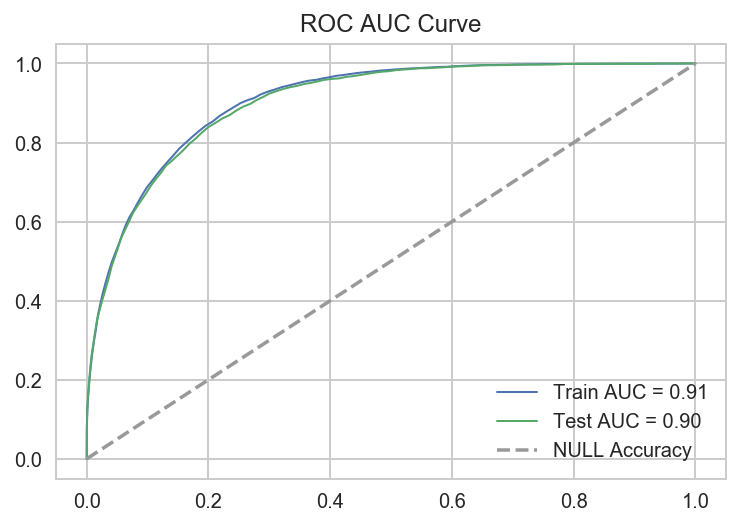

In [190]:
plt.figure(figsize=(6,4))
plt.plot(cv_train_roc_pdf['FPR'], cv_train_roc_pdf['TPR'], lw=1, label='Train AUC = %0.2f' % (cv_train_summary.areaUnderROC))
plt.plot(cv_test_roc_pdf['FPR'], cv_test_roc_pdf['TPR'], lw=1, label='Test AUC = %0.2f' % (cv_test_summary.areaUnderROC))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='NULL Accuracy')
plt.title('ROC AUC Curve')
plt.legend();

## 12. Save & Load the Model

We can now save our fitted Pipeline for later use with streaming events. This saves both the feature extraction stage and the best logistic regression model chosen by model tuning.

Before we save the Pipeline we need to add back the last layer that we chopped off.

### 12.1 Save the Model to the file system for later use

In [191]:
type(cvModel.bestModel)

pyspark.ml.pipeline.PipelineModel

**Add the Chopped off Last Layer to the Pipeline again:**

In [192]:
cvModel.bestModel.stages.append(last_stage)

In [193]:
cvModel.bestModel.stages[-1]

LogisticRegression_40d7a99f2f793e4ea2d5

In [194]:
MODEL_PATH = "model/census_pipeline_model"

In [195]:
cvModel.bestModel.write().overwrite().save(MODEL_PATH)

The result of saving the pipeline model is a JSON file for metadata and a Parquet for model data. We can re-load the model with the load command, the original and re-loaded models are the same:

![s](assets/model-diretory-structure.png)

### 12.2 Reload the Model from the file system for use in a different context

In [196]:
same_pipeline_model = PipelineModel.load(MODEL_PATH)

**Re-check with our best logistic regression model and this deserialized model's last stage to be same or not:**

In [197]:
# Explains a single param and returns its name, doc, and optional default value and user-supplied value in a string.
for param in ['regParam', 'elasticNetParam', 'maxIter', 'tol']:
    same_pipeline_model.stages[-1].explainParam(param)

'regParam: regularization parameter (>= 0) (current: 0.001)'

'elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty (current: 0.0)'

'maxIter: maximum number of iterations (>= 0) (current: 20)'

'tol: the convergence tolerance for iterative algorithms (>= 0) (current: 1e-06)'

In [198]:
# Explains a single param and returns its name, doc, and optional default value and user-supplied value in a string.
for param in ['regParam', 'elasticNetParam', 'maxIter', 'tol']:
    best_log_reg_model.explainParam(param)

'regParam: regularization parameter (>= 0) (default: 0.0, current: 0.001)'

'elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty (default: 0.0)'

'maxIter: maximum number of iterations (>= 0) (default: 100, current: 20)'

'tol: the convergence tolerance for iterative algorithms (>= 0) (default: 1e-06)'

> The `'regParam'` and `'maxIter'` were provided by us and we see they are the same as the best model that resulted out of cross validation.

**Generate Predictions from the deserialized model:**

In [199]:
same_test_preds = same_pipeline_model.transform(test_df)

In [200]:
binary_classif_evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")

In [201]:
areaUnderROC = binary_classif_evaluator.evaluate(same_test_preds)
print("areaUnderROC: {0}".format(areaUnderROC))

areaUnderROC: 0.9038892934889164


In [202]:
spark.stop()